<center><img src='https://drive.google.com/uc?id=1PioHCAlQTt8LWChoMysPErSOrxOfAW0R'></center>

**AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020**

---
<center>
<h1>Głębokie przetwarzanie tekstu i mowy</br>Informatyka</br> specjalność: uczenie maszynowe

Autor: Przemysław Rośleń</br>

14 grudnia 2022
</center>
<h3>Grafowe sieci neuronowe, cz. 1</h2>


# Cel laboratorium

Przedstawione zostaną podstawowe informacje teoretyczne i zadania praktyczne, dotyczące:
- reprezentowania zbiorów danych jako grafu,
- reprezentowania sieci neuronowej jako grafu,
- określania charakterystyki grafu,
- propagowania informacji w grafie,
- podejmowania decyzji przez grafowe sieci neuronowe.

Jest to pierwsza część cyklu zajęć praktycznych z tego tematu i jest uzupełnieniem wykładu wprowadzającego tematykę grafowych sieci neuronowych.

# Przygotowanie środowiska

Obliczenia realizowane w tym laboratorium nie są złożone - mogą być z powodzeniem wykonywane na CPU na przeciętym komputerze domowym. Z powodu zastosowania w jednym miejscu polecenia javascript z API Colab, rekomendowane jest uruchamianie właśnie w google Colab. W przeciwnym wypadku należy odpowiednie wywołania usunąć, gdyż są opcjonalne.



## Biblioteka grafowych sieci neuronowych

Wykorzystana zostanie biblioteka **[PyTorch Geometric library](https://github.com/rusty1s/pytorch_geometric)**, nazywana krótko 'PyG'. Jest to rozszerzenie dla [PyTorch](https://pytorch.org/), zwierające metody implementujące grafowe sieci neuronowe (ang. Graph Neural Networks).

In [ ]:
#instalacja
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git


%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-69_kcnmb
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-69_kcnmb
  Resolved https://github.com/pyg-team/pytorch_geometric.git to comm

## Metody wizualizacji

W kilku miejscach kodu wykorzystane zostaną funkcje przygotowujące dane do wizualizacji i wyświetlające wykresy:

- graf z połączeniami między węzłami (`visualize_grap`), funkcja  wykorzystuje `draw_networkx` z biblioteki `networkx`,
- wektory dwuwymiarowe cech (`visualize_embeddings`), wykorzystanie funkcji scatter do rysowania punktów na wykresie, do danych, które posiadają tylko dwa wymiary, przykładowo wyjście ostatniej warstwy splotu w sieci grafowej,
- wektory wielowymiarowe cech (`visualize`), użyty algorytm **T-SNE** do rzutowania punktów z wielowymiarowej przestrzeni na przestrzeń 2D i "rozsuwania" ich w niej przez odpowiednie przekształcenia nieliniowe, aby **maksymalizować odległości** między obiektami różnych klas (inter-class distance) a **minimalizować** w ramach jednej klasy (intra-class distance).

In [ ]:
def visualize_graph(G, color, seed):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=seed), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Podstawowe definicje

Sieci głębokie typowo stosowane są do danych o **regularnej, stałej strukturze**, np. grafiki o określonej liczbie kanałów koloru i liczbie pikseli w wierszach i kolumnach **macierzy**.

Nie każdy praktyczny problem można zapisać w macierzy, zwłaszcza, jeśli:

- konieczne jest uwzględnianie **zależności między obiektami** i dodawane są nowe obiekty. W takiej sytuacji, zależności nie mogą być wpisane w macierz o ustalonym rozmiarze, gdyż nowy obiekt wymagałby zwiększenia rozmiaru tej macierzy i zmiany architektury sieci i jej trenowania.

Odpowiedzią na ten problem są sieci grafowe (**Graph Neural Networks (GNNs)**), które są uogólnieniem sieci splotowych, mogą działać identycznie jak one i na takich samych danych (np. obrazach) a ponadto:

- uwzględniają zależności między obiektami i umożliwiają dodawanie nowych obiektów (porównaj z ograniczeniem podanym powyżej dla sieci splotowej)
- wykorzystywane są do wnioskowania na temat obiektów, na temat ich relacji i interakcji.

## Definicja grafu

Graf definiowany jest jako węzły i krawędzie łączące je: $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ (z angielskiego: *vertices, edges*). PyG zakłada, że graf jest wyłącznie skierowany, tj. każda krawędź przebiega w jednym kierunku od węzła pierwszego do drugiego w parze. Jeśli graf ma być nieskierowany, to dwa węzły połączone są dwiema skierowanymi krawędziami o różnych zwrotach.



## Zbiory danych - wymagania

Przetwarzane dane powinny mieć charakter grafu - składać się z obiektów, między którymi istnieją opisane zależności, obiekty  łączone są w pary-relacje, każdy obiekt opisany wektorem cech $\mathbf{x}$ oraz każdy obiekt z wartością decyzji ${y}$.

Przykładowo:
- popularnie kupowany produkt A o cechach $\mathbf{x}$ i inne produkty B, C, D,... typowo kupowane razem z produktem A;
- publikacja naukowa o słowach kluczowych $\mathbf{x}$ i publikacje B, C, D,... cytujące ją.
- atomy połączone w cząsteczkę - graf definiuje jej strukturę, algorytm przewiduje brakujący atom lub klasyfikuje cały graf jako związek toksyczny lub nie.
- i wiele innych.

Warto także rozważyć sytuację, gdy dane np. obraz, typowo analizowane przez sieci niegrafowe (np. konwolucyjne), są przetwarzane siecią grafową. Piksel jest węzłem, ma cechy - kolor, ma sąsiedztwo - inne piksele i wówczas obraz także może być wejściowym grafem.

## Zadanie do wykonania

Przedyskutować inne przykłady danych, które mogą być wyrażone w formie grafu, przykłady zagadnień, które mogą zyskać na tym, że będą przetwarzane grafową siecią a nie splotową lub wielowarstwową.

Podać co może być obiektem-wierzchołkiem, jaki jest opis cech wierzchołka, czy krawędzie są skierowane czy nie.

### Przykłady:
- sieci społecznościowe: wierzchołkiem jest konto użytkownika, a krawędziami znajomości/obserwowanie.
- połączenia telefoniczne: wierzchołkiem jest użytkownik, a krawędziami połączenia

## Aktualizacja grafu

Działanie sieci grafowej uwzględnia mechanizm nazywany przekazywaniem wiadomości (ang. **neural message passing scheme**), w którym cechy $\mathbf{x}_v^{(\ell)}$ zapisane w węzłach $v \in \mathcal{V}$ połączonych ze sobą w grafie $\mathcal{G}$ są iteracyjnie aktualizowane poprzez **agregowanie informacji od sąsiednich węzłów**, połączonych z nimi $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

gdzie:
- $\ell$ to krok iteracji,
- $\mathcal{N}(v)$ to zbiór węzłów o krawędziach łączących je z $v$,
- $\mathbf{x}_v$ to wektor cech węzła $v$,
- $f$ to funkcja agregująca, przyjmująca jako argument cechy węzła $v$ i całego jego sąsiedztwa.

**Agregacja informacji** z węzła i sąsiadów może przebiegać na różne sposoby: poprzez średnią, średnią ważoną, konkatenację (złączenie wektorów atrybutów), itd.

## Charakterystyka zbioru danych

[**Zachary's karate club network (Wikipedia)**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) to popularny zbiór danych, wykorzystywany w badaniu dynamiki społecznej, przedstawiający jako nieskierowany graf interakcje między 34 osobami w tytułowym klubie. Obecność krawędzi między dwiema osobami oznacza, że znają się prywatnie poza klubem. W zbiorze tym klasy to numery grup, które powstały z takich interakcji.

W przykładzie tym krawędzie nie mają różnicowanych wag (co może być spotykane w wielu innych zagadnieniach).

Dane pozyskane zostaną z [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets).

Odpowiednie pola przechowują charakterystyki zbioru (kod poniżej).

Pamiętać należy, że w `PyG` każdy graf definiowany jest przez:
- `edge_index` krotki z połączeniami: początek i koniec krawędzi skierowanej.
- `x` atrybuty/cechy węzła, tu przykładowo wektory 34-elementowe.
- `y` etykiety klas
- `train_mask` flagi `bool` oznaczające, które węzły są w zbiorze treningowym, czyli, klasy których węzłów należy traktować jako dane uczące.

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Liczba grafów w zbiorze: {len(dataset)}')
print(f'Liczba atrybutów: {dataset.num_features}')
print(f'Liczba klas: {dataset.num_classes}')

Dataset: KarateClub():
Liczba grafów w zbiorze: 1
Liczba atrybutów: 34
Liczba klas: 4


### Miary

Możliwe jest odczytanie innych, specyficznych dla teorii grafów, miar:

In [ ]:
data = dataset[0]  #w zbiorze jest 1 graf, dostęp do niego przez indeks [0]

print(data) #metoda dla obiektu graf klasy `Data` wyświetli jego ogólny opis
print('==============================================================')

# Inne miary opisujące graf
print(f'Liczba węzłów: {data.num_nodes}')
print(f'Liczba krawędzi: {data.num_edges}')
print(f'Średni stopień węzła/wierzchołka (liczba połączeń z bezpośrednimi sąsiadami): {data.num_edges / data.num_nodes:.2f}')
print(f'Liczba węzłów w zbiorze treningowym: {data.train_mask.sum()}')
print(f'Względny rozmiar zbioru treningowego: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Obecność izolowanych węzłów: {data.has_isolated_nodes()}')
print(f'Obecność pętli: {data.has_self_loops()}')
print(f'Czy graf jest nieskierowany: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Liczba węzłów: 34
Liczba krawędzi: 156
Średni stopień węzła/wierzchołka (liczba połączeń z bezpośrednimi sąsiadami): 4.59
Liczba węzłów w zbiorze treningowym: 4
Względny rozmiar zbioru treningowego: 0.12
Obecność izolowanych węzłów: False
Obecność pętli: False
Czy graf jest nieskierowany: True


### Podzbiór uczący

W tym zbiorze nie są to losowe węzły / obiekty do nauki, tylko celowo wybrane zostały po jednym reprezentancie każdej klasy.

Pozostali mają być "znalezieni" (sklasyfikowani) w procesie uczenia sieci, polegającego na wywnioskowaniu właściwych klas.

In [ ]:
print("Maska węzłów zbioru uczącego:")
print(data.train_mask)
print(f"\nLiczba wartości True == liczba węzłów treningowych: {data.train_mask.sum()}")
print("\nKlasy kolejnych węzłów:")
print(data.y)

Maska węzłów zbioru uczącego:
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

Liczba wartości True == liczba węzłów treningowych: 4

Klasy kolejnych węzłów:
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


### Opis krawędzi grafu

Lista krawędzi `edge_index` pozwala zweryfikować cechy grafu:

Jeśli $(v, v) \in \mathcal{E}$ to krawędź jest pętlą.

Jeśli dla każdej krawędzi $(v, w) \in \mathcal{E}$ istnieje również krawędź $(w, v) \in \mathcal{E}$) to graf jest nieskierowany.

In [ ]:
from IPython.display import Javascript
#Dla czytelności wyświetlania wyniku wysokość ramki Iframe jest ograniczana, będzie wymagała przewijania zawartości
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t()) #transponowany

Zasada przyjęta w `edge_index` to tzw. **COO format (coordinate format)** wykorzystywany do wydajnej reprezentacji macierzy rzadkich (ang. *sparse*), czyli wyłącznie komórki macierzy, które posiadają wartość niezerową.

### Wizualizacja zbioru danych

Wizualizacja grafu może być wykonana z użyciem biblioteki `networkx`:

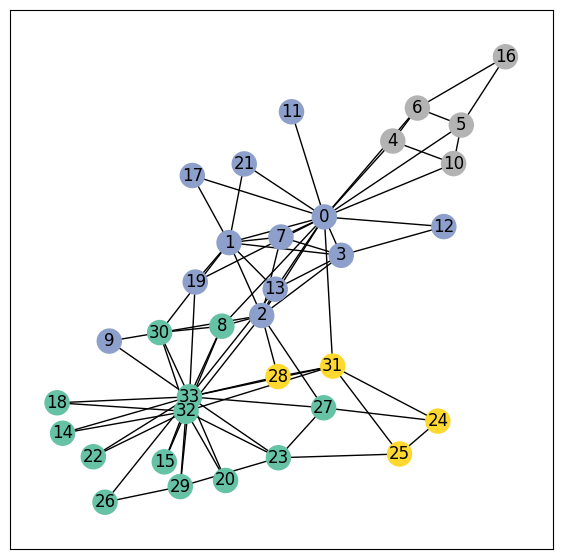

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y, seed = 321321) #patrz definicja funkcji visualize_graph na początku notatnika.

Kolory oznaczają każdą z czterech klas. Połączenia to krawędzie. Położenie na wykresie jest przypadkowe i inicjowane jest wartością `seed`, wynika z metody rysowania "sprężystego" wykresu `nx.spring_layout`. Możliwe jest uzyskanie innych, czytelniejszych wykresów poprzez zmianę tego argumentu.

## Uczenie i wnioskowanie z użyciem Grafowych Sieci Neuronowych

Powyżej podane zostało, że przekazywanie w grafie informacji polega na zastosowaniu funkcji agregacji. Jedną z najprostszych jest średnia ważona, tj. operator **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)):

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

Gdzie:
- $\mathbf{W}^{(\ell + 1)}$ to wagi podlegające uczeniu, ustalające w jaki sposób atrybuty/cechy są sumowane
- $c_{w,v}$ to współczynnik normalizacji dla każdej krawędzi, $c_{w,v} = \sqrt{d_wd_v}$, gdzie $d_i = |\mathcal{N}(i)|$ to rząd węzła.

W rezultacie cała informacja w $v$-tym węźle w kolejnym kroku jest wynikiem przetworzenia informacji z niego i wszystkich węzłów połączonych, z wcześniejszego kroku.

W zależności od rozmiaru macierzy $\mathbf{W}$, w kroku $v+1$ rozmiar wektora cech może się zmienić.

Kod implementujący sieć z warstwami GCN:

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  #cechy w przestrzeni 2-wymiarowej, ang. embeddings, zwracane przez funkcję, użyteczne w wizualizacji

        #klasyfikacja do num_classes
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


## Zadanie do wykonania

### Opis zadania

Przeanalizować należy powyższy kod, zidentyfikować w nim znane wcześniej elementy (np. z sieci splotowych), przedyskutować znaczenie argumentów funkcji `GCNConv(,)` oraz znaczenie kolejnych poleceń w metodzie `forward`. Spostrzeżenia i wnioski należy sformułować i przedstawić ustnie w trakcie zajęć.

### Ważne wskazówki

Metoda `__init__` definiuje składowe elementy, a sposób obliczeń definiowany jest w metodzie `forward`.

Wykorzystanie trzykrotnie **grafowych warstw splotowych** skutkuje trzykrotnym agregowaniem sąsiedztw wszystkich węzłów:
- w pierwszym kroku każdy węzeł aktualizowany jest informacją z sąsiadów,
- w drugim kroku z sąsiadów, którzy zostali także zaktualizowani (czyli przekazywana jest przetworzona informacja z sąsiadów drugiego rzędu),
- podobnie w kroku trzecim.

Przekazywana przetworzona informacja nie zachowuje swojego oryginalnego formatu, tylko poddawana jest redukcji wymiarowości i nieliniowemu przekształceniu `tanh` (zauważyć należy odpowiednie miejsca w kodzie).

Po trzech warstwach w każdym węźle zamiast wektora 34 cech są wektory 2-wymiarowe, które wykorzystywane są w warstwie klasyfikującej (klasyfikator liniowy o 4 klasach).

### Zadanie 2
Znaczenie kolejnych argumentów w metodzie GCNConv to: in_channels, out_channels.
Zanczenie kolejnych linii kodu w metodzie `forward(...)`:
- self.conv_i(x, edge_index): przekształca cechy węzłów grafu, uwzględniając informacje o sąsiedztwie określonym przez edge_index.

- h.tanh(): funkcja tangensa hiperbolicznego do przetworzonych cech po danej warstwie

- self.classifier(h): dokonuje klasyfikacji przetworzonych cech na przestrzeni 2-wymiarowej na przestrzeń klas. Wynikiem jest tensor z przewidywaniami klas.

return out, h: Zwraca wyniki klasyfikacji (out) oraz przetworzone cechy w przestrzeni 2-wymiarowej (h).

# Test niewytrenowanego modelu

Wykonana jest wizualizacja wartości cech na wyjściu ostatniej warstwy splotowej grafowej, czyli dwuwymiarowych wektorów opisu (ang. *embedding*).

Rozmiar uzyskanego wektora cech: [34, 2]


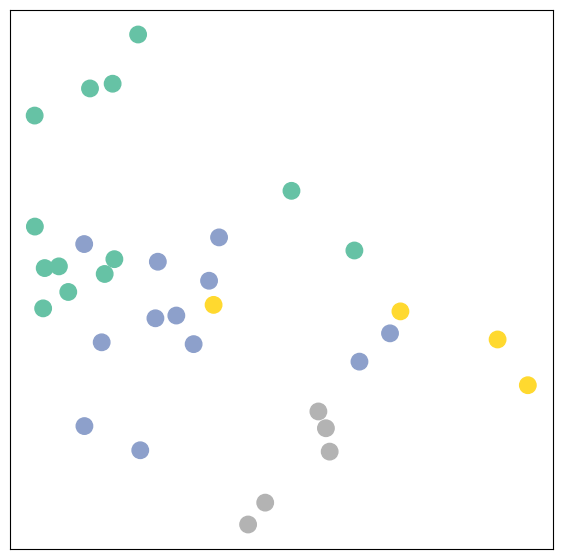

In [ ]:
model = GCN()

out, h = model(data.x, data.edge_index)
# zwracane out to klasa, h to wektory cech z ostatniej warstwy
print(f'Rozmiar uzyskanego wektora cech: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Wewnątrz modelu przebiega sumowanie wartości cech z sąsiadów (początkowo zainicjowane w sposób losowy). Cechy to opis określający, z którymi osobami kontaktuje się każda osoba. Zauważyć można, że model taki posiada już początkowo zdolność ustawiania w przestrzeni dwuwymiarowej "*embeddingów*" tak, że osoby jednej klasy mają zbliżone wartości cech.

Bez względu na wagi, sama zasada działania sieci GNN, wywołuje silną tendencję (ang. *bias*): wartości "*embeddingów*" są zbliżone dla węzłów, które są połączone jedną lub pośrednio dwiema, trzema krawędziami.

# Trening modelu

Powyżej uzyskana zdolność modelu do wyliczania odpowiednio wartości "*embeddingów*" jest objawem zdolności samouczenia (ang. *unsupervised*, *self-supervised*).

W procesie treningu wagi $\mathbf{W}$ będą modyfikowane w celu maksymalizowania trafności klasyfikacji na zbiorze uczącym. W wyniku tej nauki uzyskane zostaną inne przekształcenia wejściowych wektorów 34 cech w każdym węźle, do wynikowego 2-wymiarowego.

Stosowane tu podejścje jest to uczenie częściowo nadzorowane, (ang. *semi-supervised*, *transductive*). Cel jest osiągany dla jednego węzła na klasę (patrz: **maska** definiująca zbiór uczący), ale uczenie wykorzysta całą informację z grafu, wszystkie wektory 34 cech.

*Transductive learning*: **rozumowanie przez podobieństwo**, przechodzenie od jednego wniosku do drugiego bez konieczności modelowania ogólnej reguły, czy zasady, jaka łączy poszczególne elementy lub zdarzenia.

Zdefiniowane jest kryterium straty (loss) `CrossEntropyLoss` oraz optymalizacja wag na bazie gradientu `Adam`. Strata uwzględnia tylko `data.train_mask`, czyli liczona jest dla 4 węzłów, po jednym na klasę.

Poniżej wyświetlane są wszystkie wizualizacje "*embeddingów*"  wyjściowych, dwuwymiarowych, po każdych dziesięciu epokach  treningu.

<IPython.core.display.Javascript object>

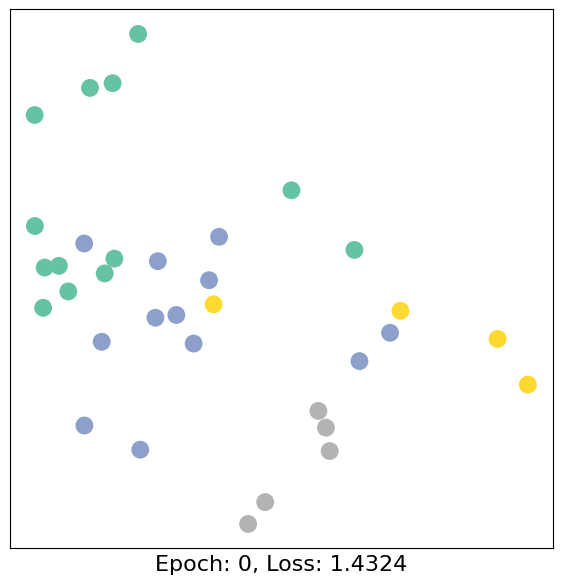

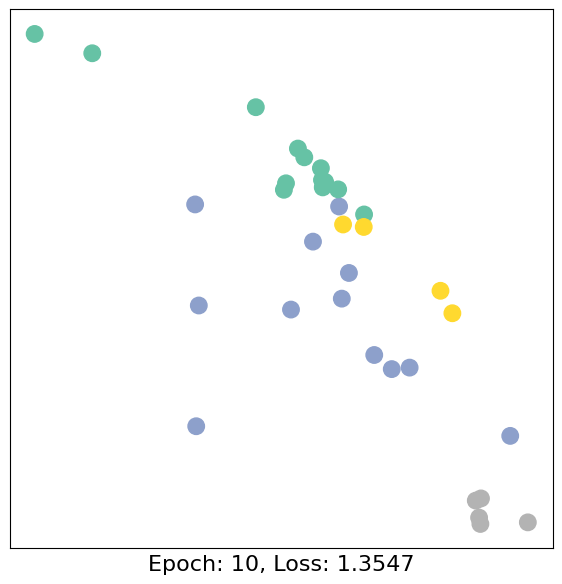

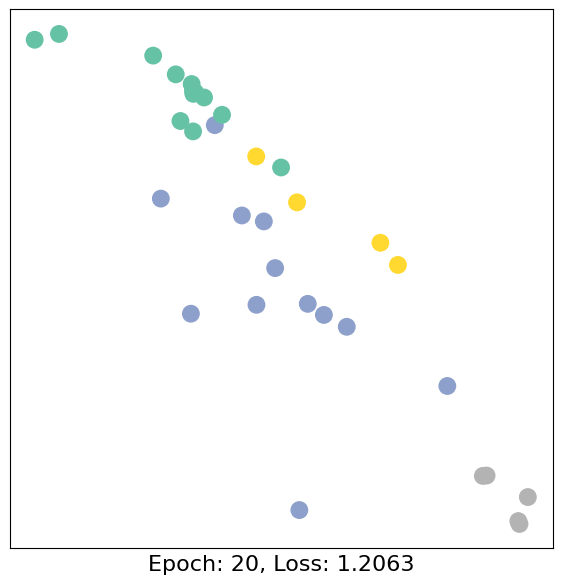

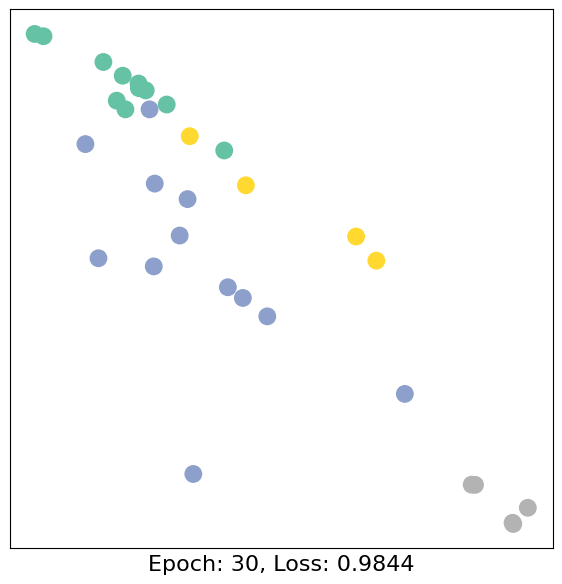

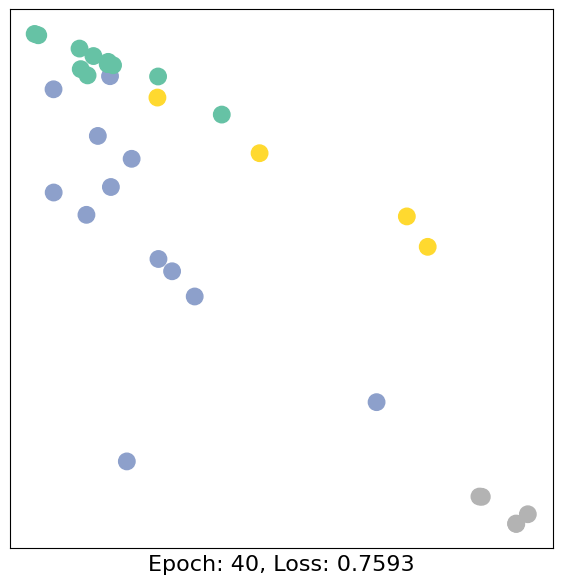

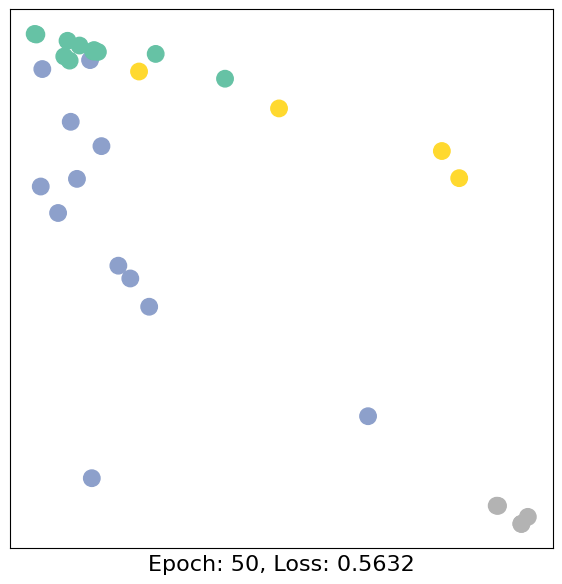

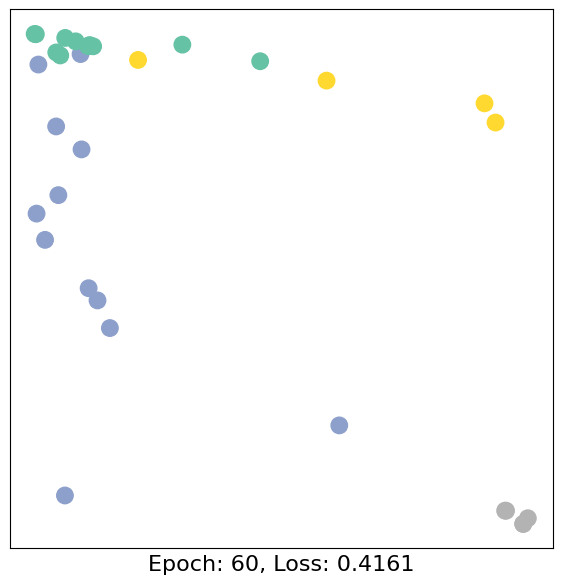

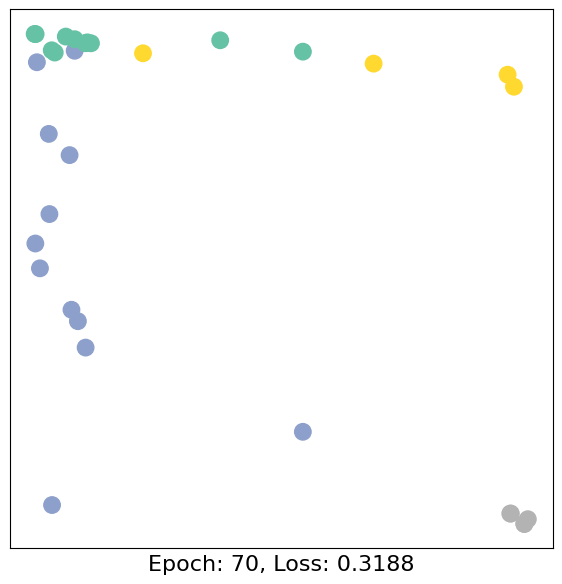

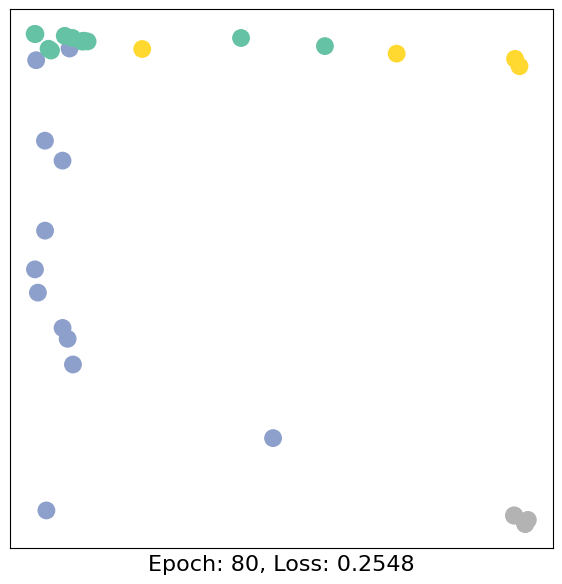

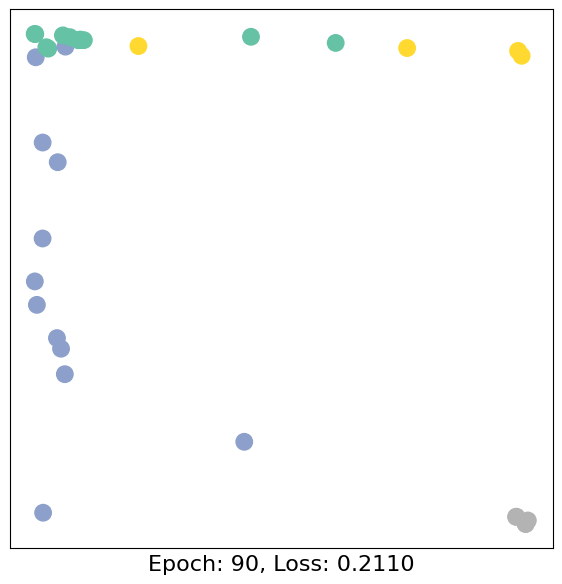

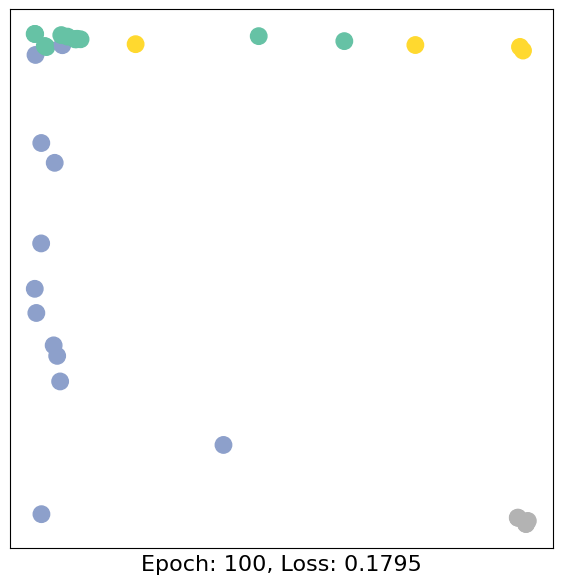

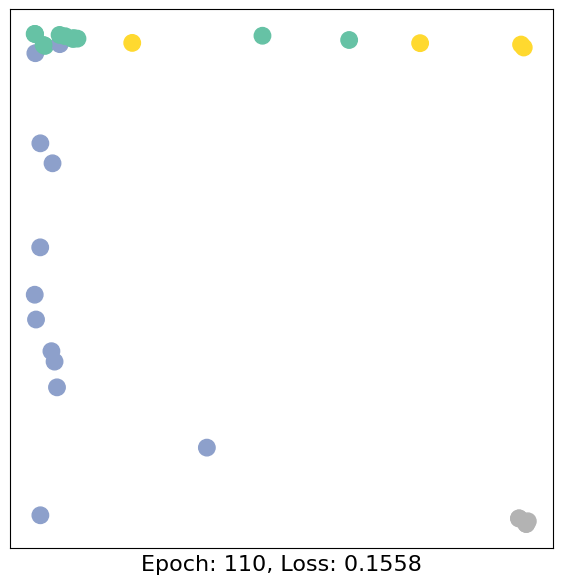

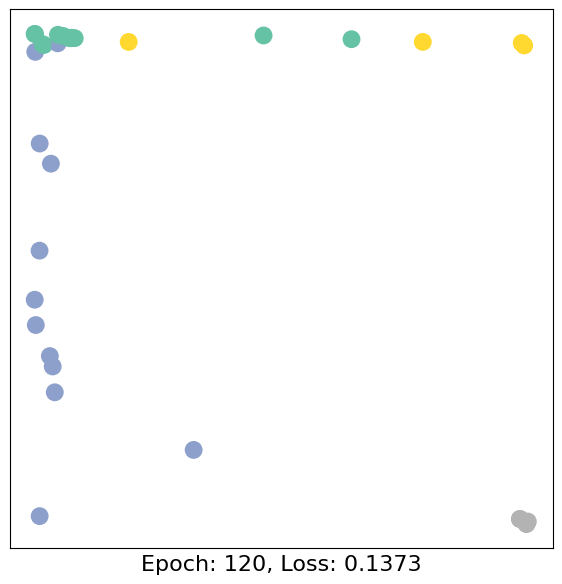

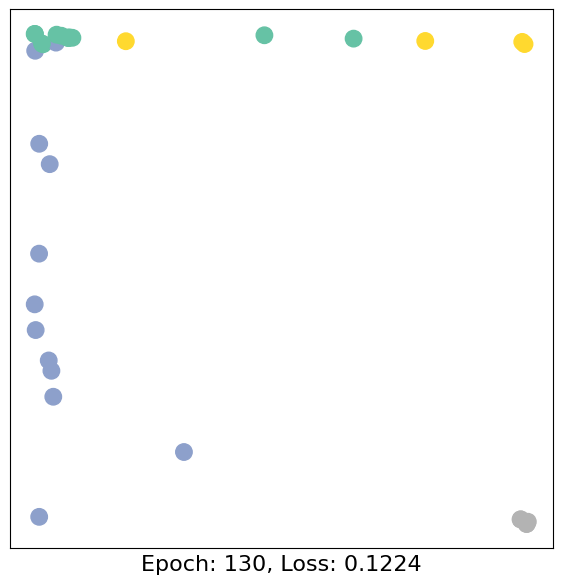

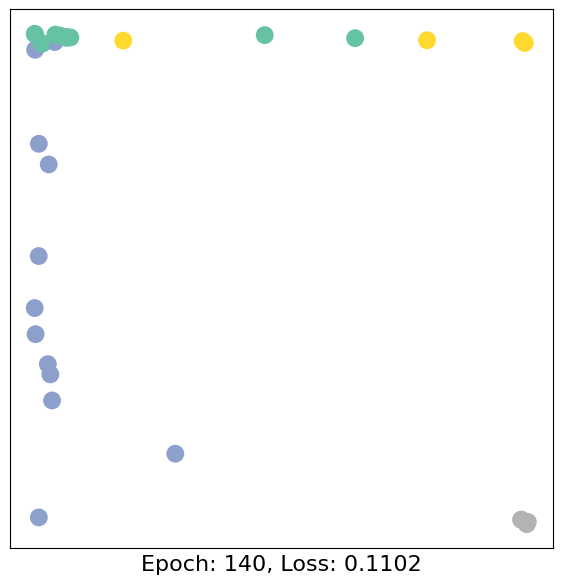

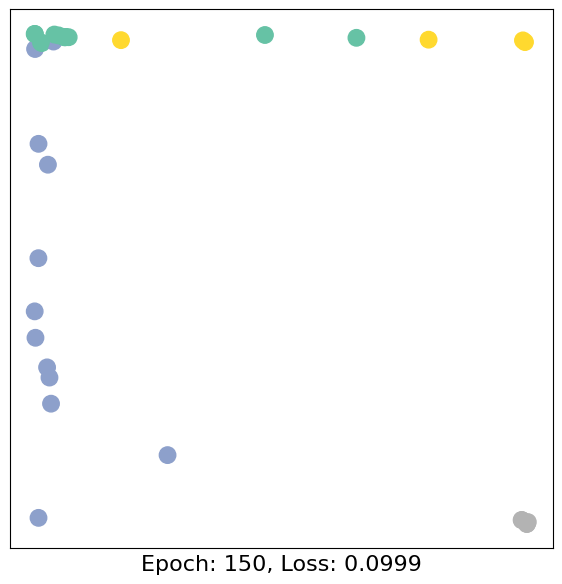

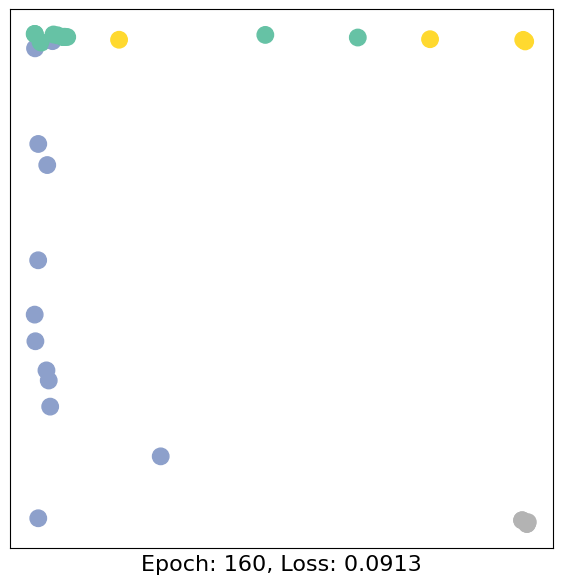

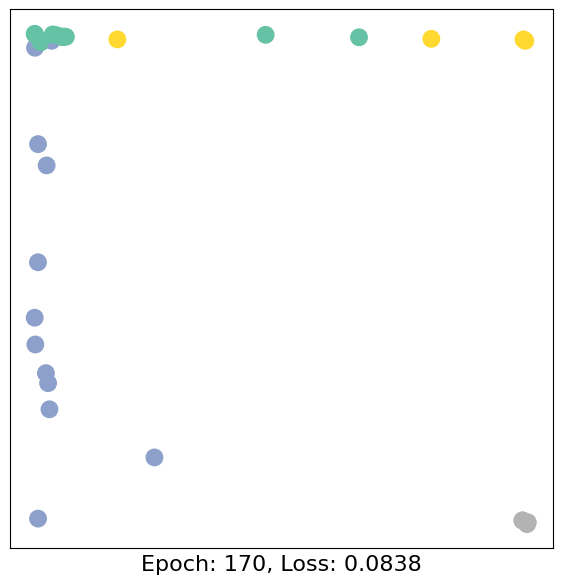

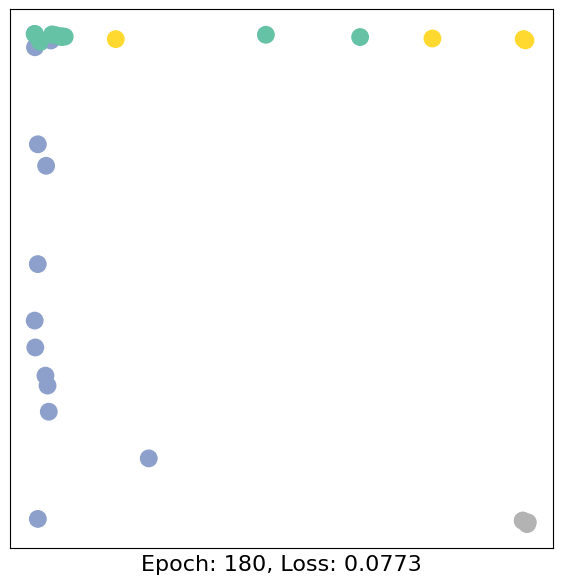

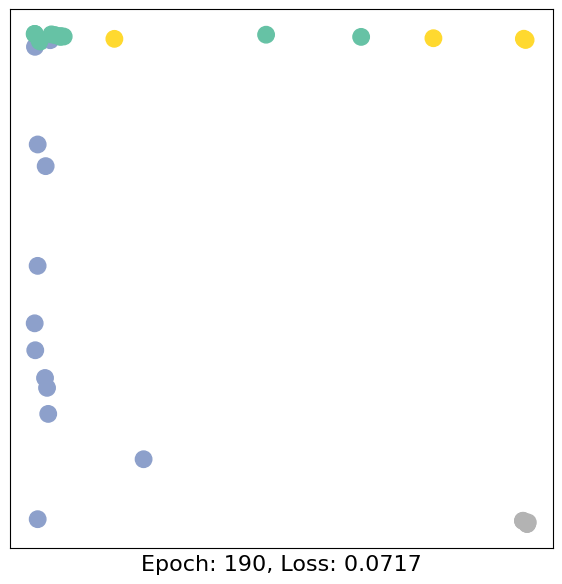

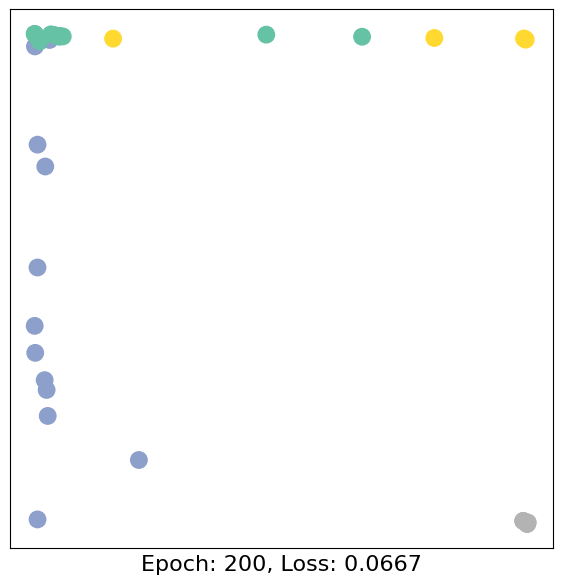

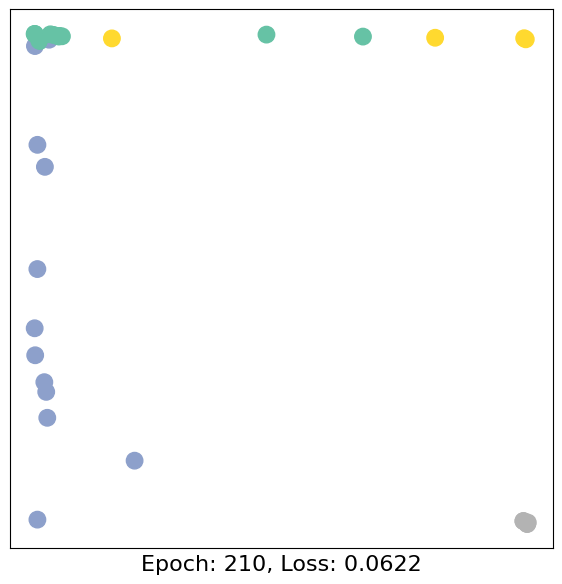

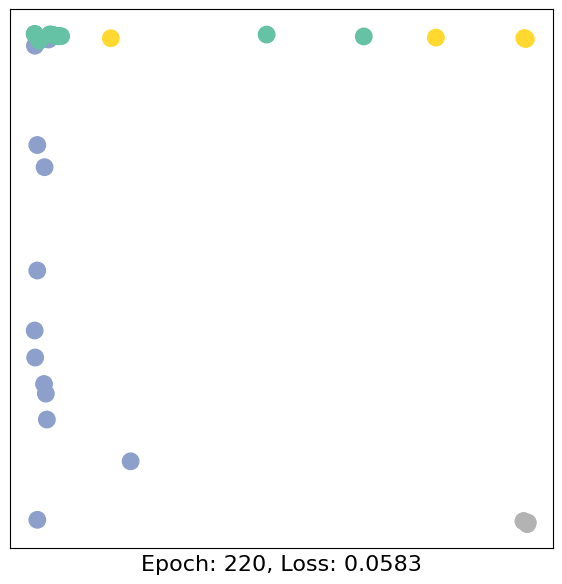

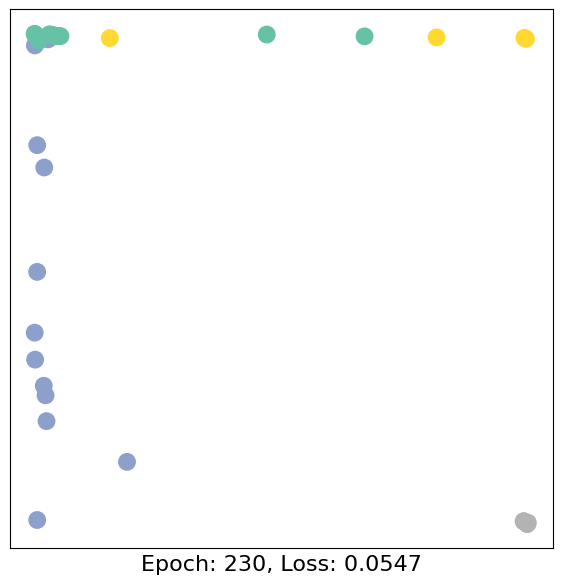

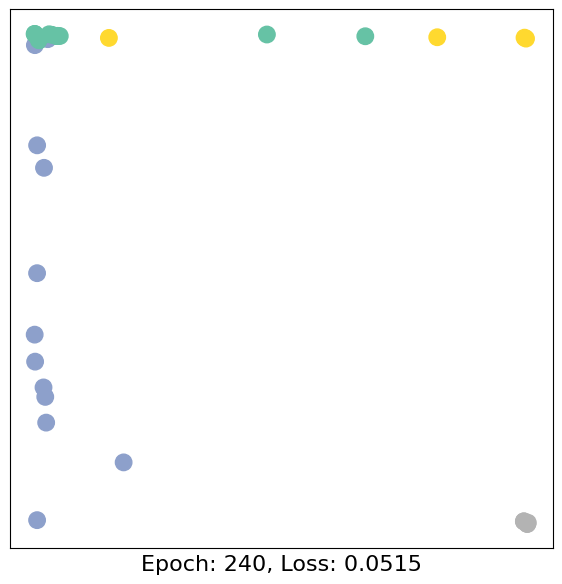

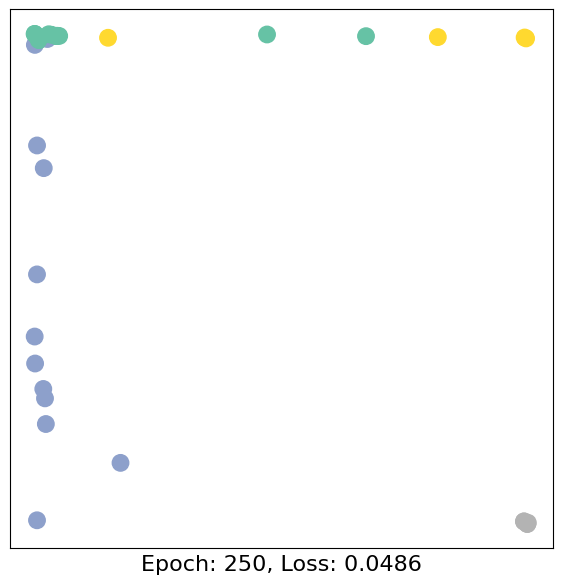

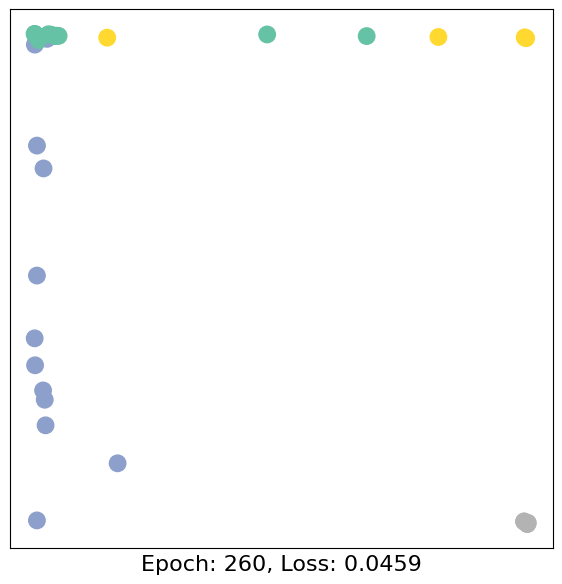

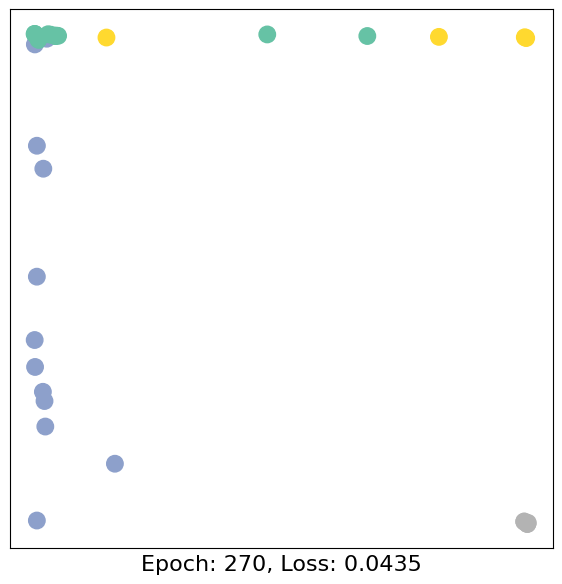

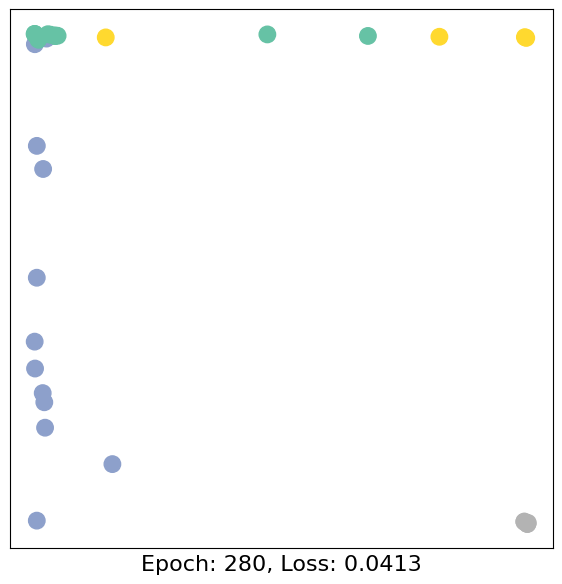

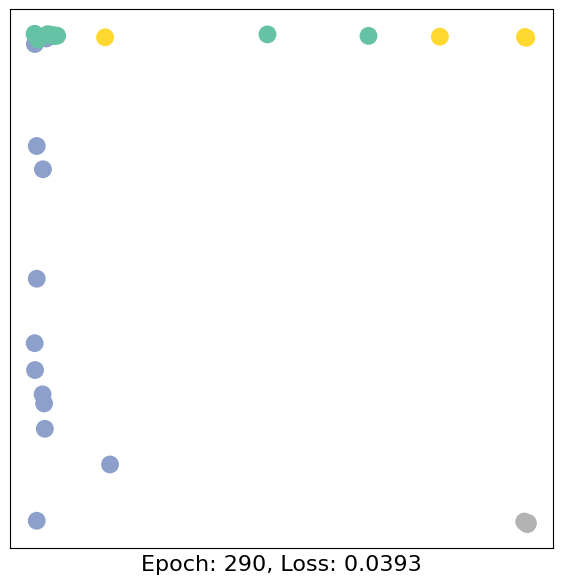

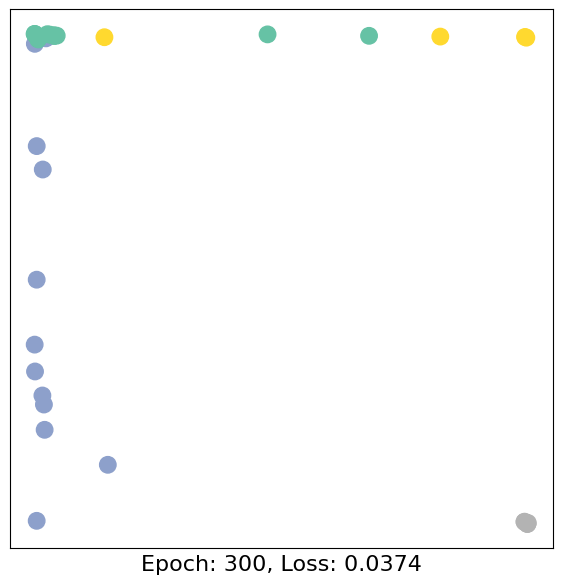

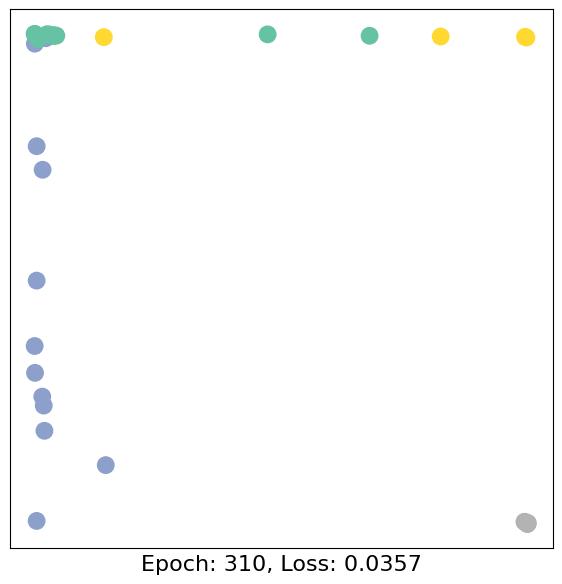

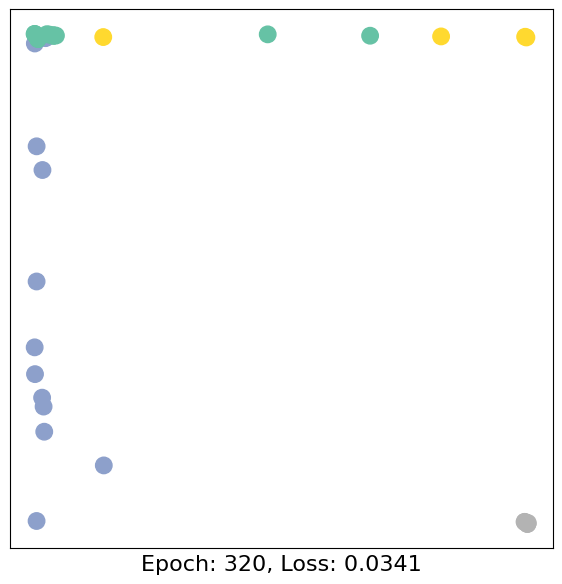

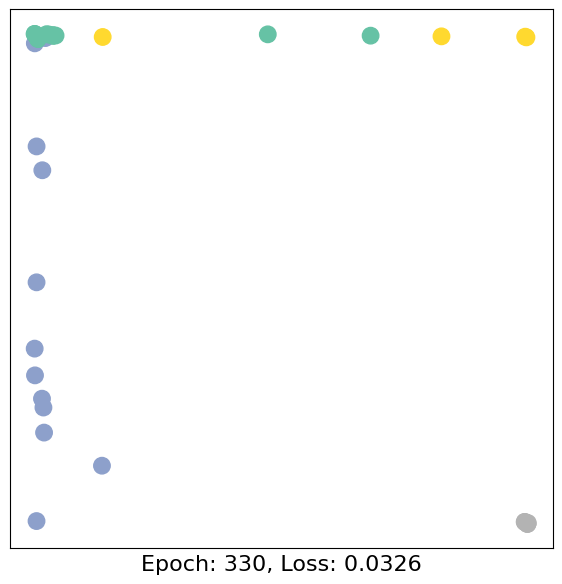

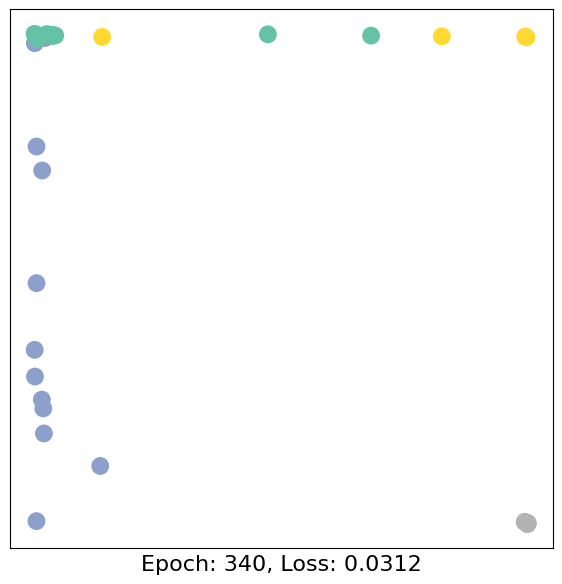

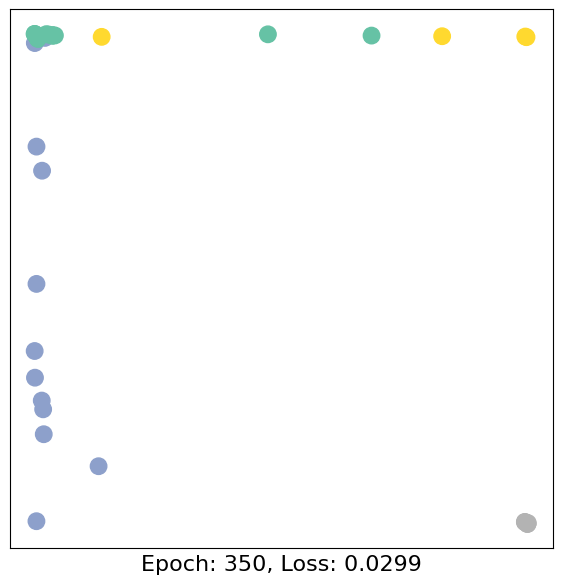

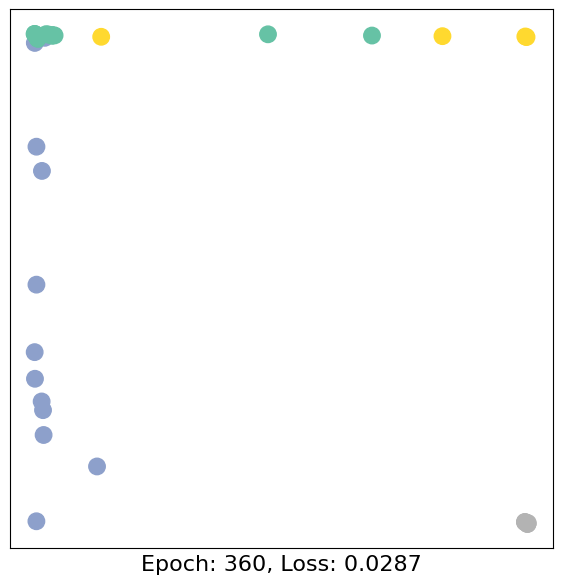

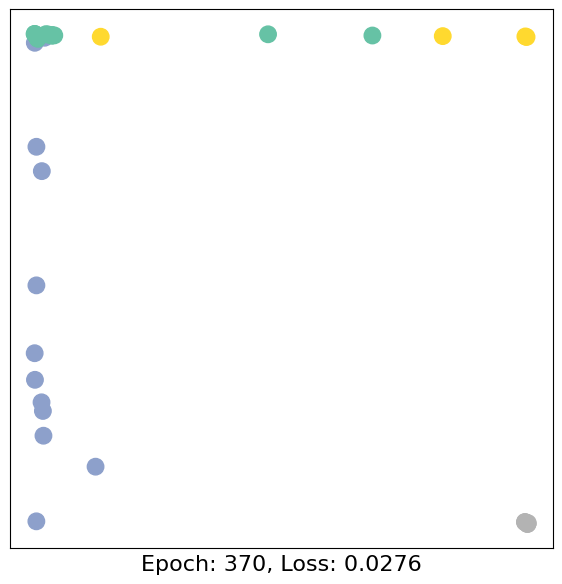

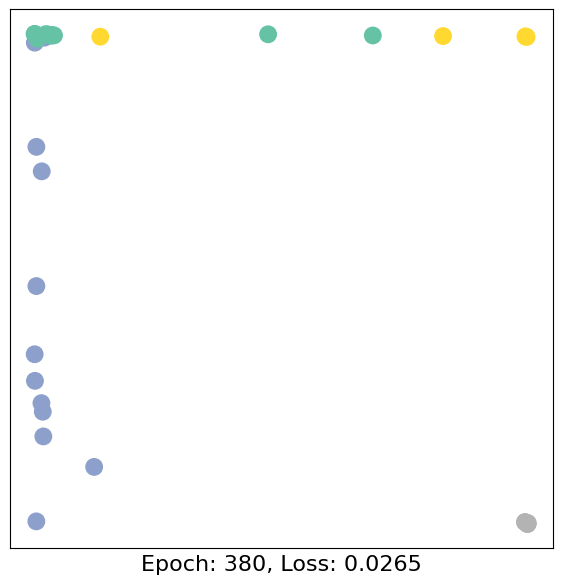

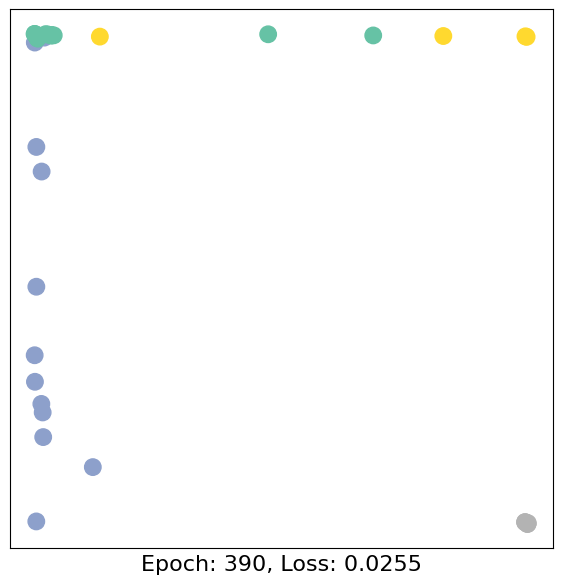

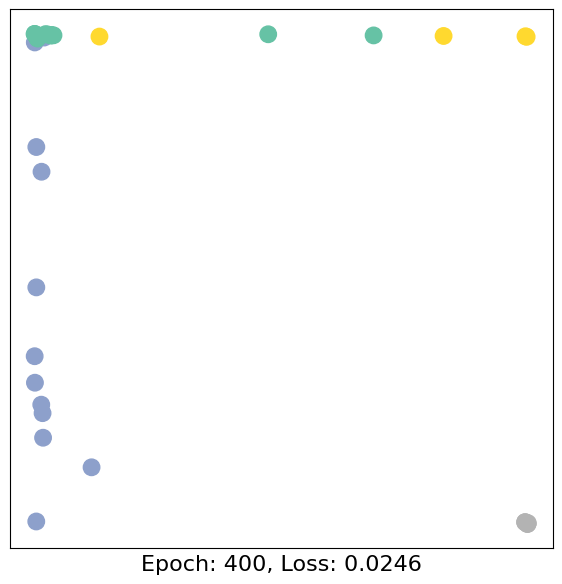

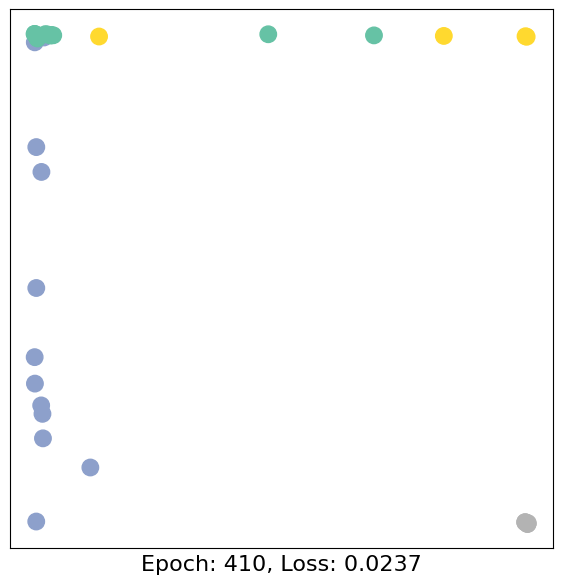

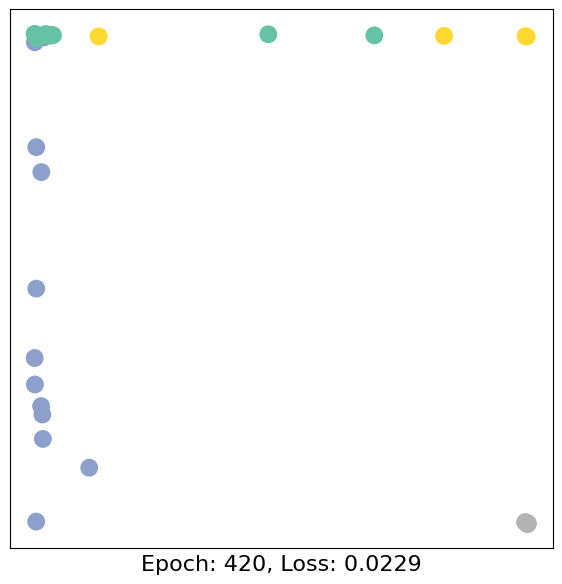

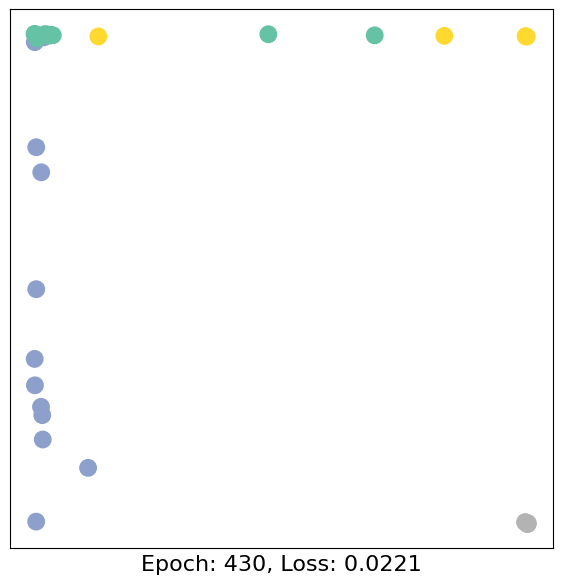

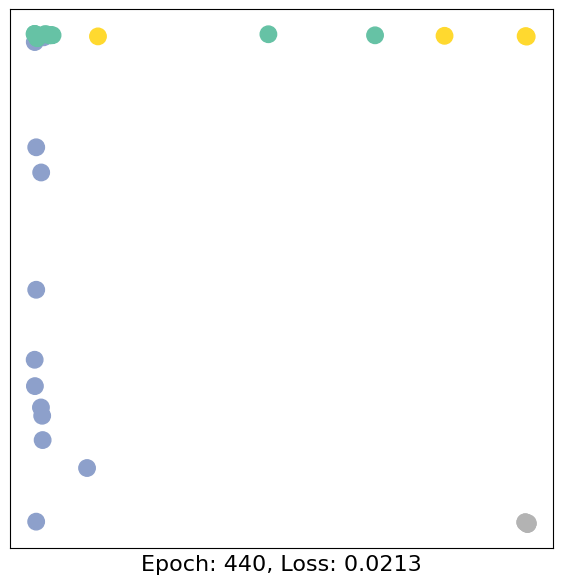

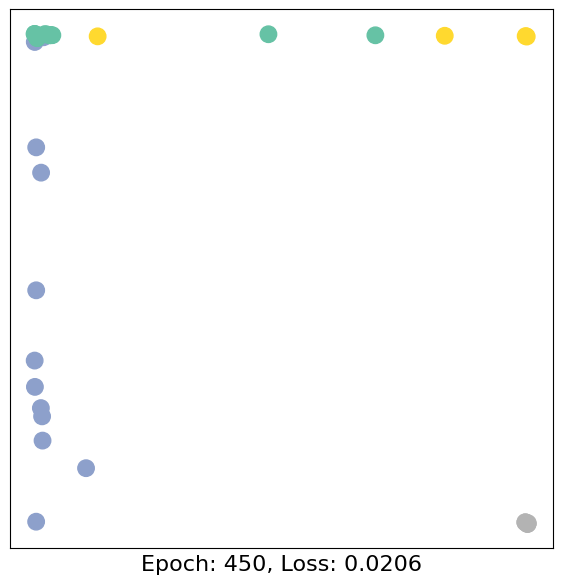

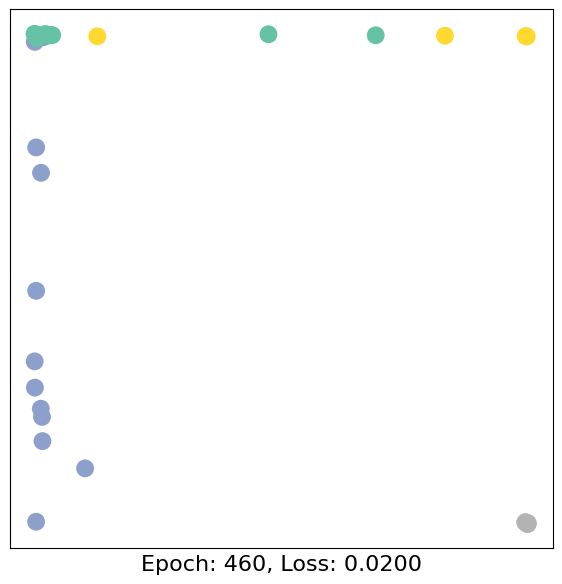

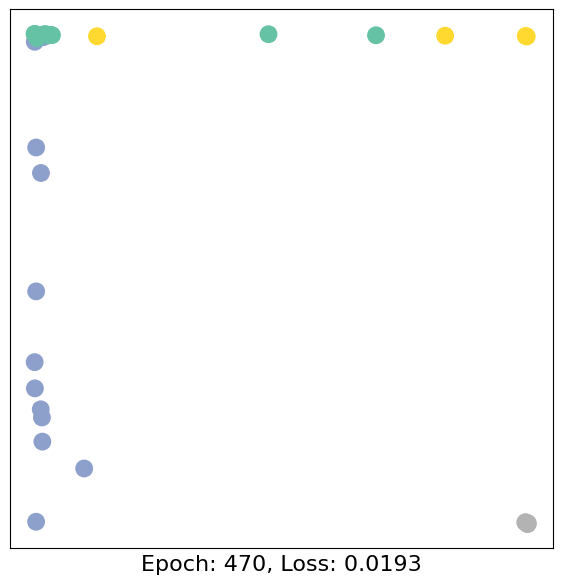

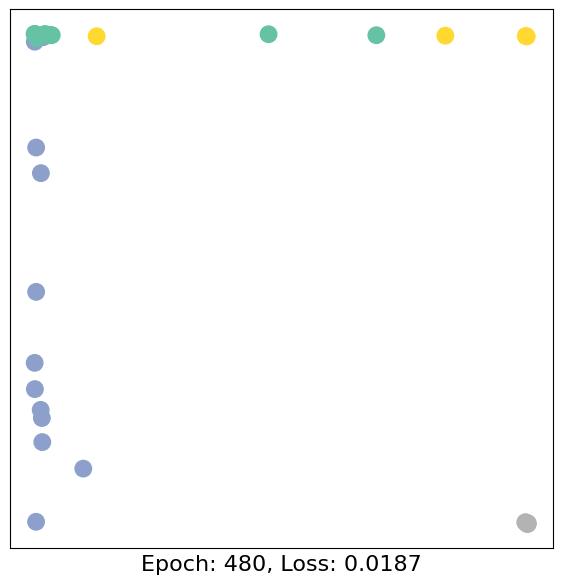

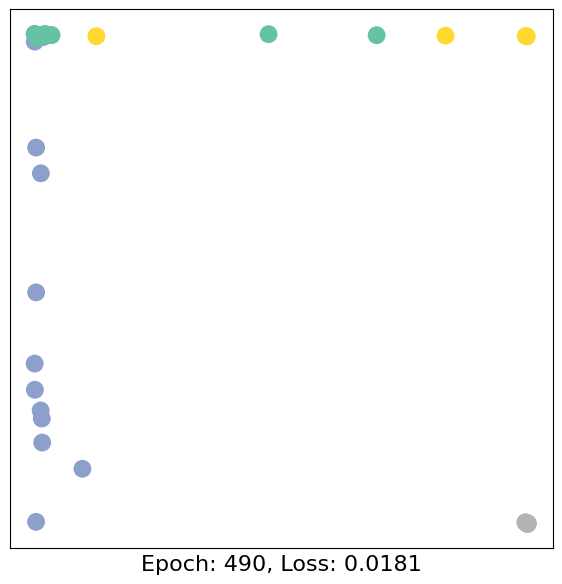

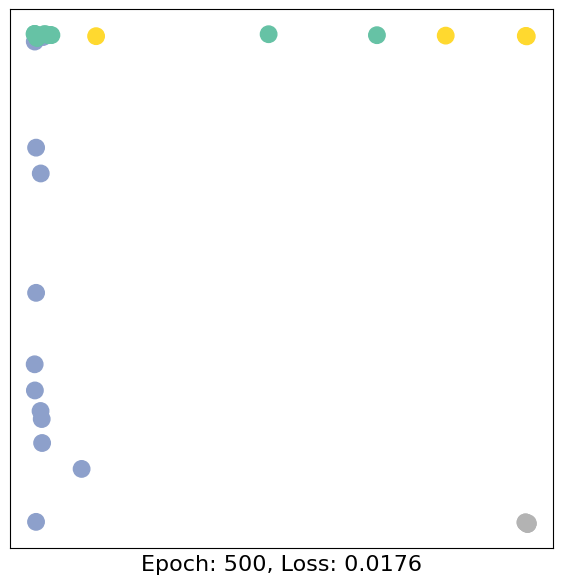

In [ ]:
import time
from IPython.display import Javascript
#Dla czytelności wyświetlania wyniku wysokość ramki Iframe jest ograniczana, będzie wymagała przewijania zawartości
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()  #wyzerowanie gradientów
    out, h = model(data.x, data.edge_index)  #przebieg "wprzód"
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  #strata loss obliczana wyłącznie na węzłach ze zbioru uczącego
    loss.backward()  #wyliczenie gradientów (wsteczna propagacja błędu)
    optimizer.step()  #aktualizacja trenowalnych wag modelu
    return loss, h

for epoch in range(501):
    loss, h = train(data)
    if epoch % 10 == 0: #jeśli co dziesiąta:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3) #bez pauzy zawodzi wyświetlanie...

## Zadanie do wykonania

Zaobserwować na podstawie powyższego procesu treningu jak stopniowo rozdzielają się i stają się liniowo separowalne klasy.

### Odpowiedź
Widać, że klasa 'szara' jest najlepiej i najszybciej 'rozdzielana' (po ~40 epokach). Pozycje obiektów klas: 'zółtej' i 'zielonej' również są szybko 'rozdzielane', jednak nieskutecznie - są przemieszane. Jeden z obiektów klasy niebieskiej 'zbiegał' do klastra bardzo powoli - ~500 epok.

# Test modelu

Wykorzystana jest funkcja wyliczająca metrykę `accuracy`.

In [ ]:
def test():
      model.eval()
      out, _ = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  #wykorzystanie tylko klasy z maksymalnym prawdopodobieństwem, po wierszach, patrz zawartość zmiennej: out
      test_correct = pred[~(data.train_mask)] == data.y[~(data.train_mask)]  #obliczenia tylko dla nie-trenujących
      test_acc = int(test_correct.sum()) / int((~(data.train_mask)).sum())  #odsetek poprawnych
      return test_acc

In [ ]:
model.eval()
out, _ = model(data.x, data.edge_index)
out

tensor([[-0.2117,  4.6997, -4.7945,  0.1435],
        [ 1.3889,  3.1136, -3.2633, -1.4426],
        [ 4.6456, -0.1601, -0.0931, -4.6622],
        [ 1.1232,  3.3770, -3.5176, -1.1793],
        [-4.2213,  0.8377,  0.5880,  5.3932],
        [-4.2534,  0.8373,  0.5952,  5.4303],
        [-4.2534,  0.8372,  0.5953,  5.4303],
        [ 2.0985,  2.3776, -2.5459, -2.1405],
        [ 4.6629, -0.2191, -0.0274, -4.6726],
        [ 4.6236, -0.2711,  0.0421, -4.6187],
        [-4.2216,  0.8374,  0.5884,  5.3936],
        [-0.0497,  3.8035, -3.7740,  0.1027],
        [ 0.5340,  3.8527, -3.9540, -0.5778],
        [ 3.5640,  0.9052, -1.1202, -3.5894],
        [ 4.5942, -0.3378,  0.1267, -4.5740],
        [ 4.5918, -0.3403,  0.1301, -4.5709],
        [-4.2488,  0.8277,  0.6055,  5.4265],
        [ 0.7790,  3.6129, -3.7231, -0.8211],
        [ 4.5890, -0.3452,  0.1365, -4.5668],
        [ 3.2654,  1.1303, -1.3226, -3.2819],
        [ 4.5748, -0.3570,  0.1533, -4.5485],
        [ 0.8696,  3.5406, -3.6570

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.80


In [ ]:
print(data.train_mask)
print(data.y)
data.train_mask[7]=True
print(data.train_mask)

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
tensor([ True, False, False, False,  True, False, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


## Zadanie do wykonania - praca z kodem

Utworzyć należy nową komórkę, w której powtórzone zostaną: definicja sieci, trening i jej test.

Następnie modyfikować należy hiperparametry i obserwować zmiany skuteczności klasyfikacji:
- liczba i wymiary warstw a wynik `accuracy`
- wielkość zbioru uczącego - edytować maskę, liczbę węzłów na klasę zwiększyć do 2 (zaobserwować data.y, data.train_mask, przypisywać `data.train_mask[indeks]=True|False`) a wynik `accuracy`.

Sformułować wnioski.

Czy zwiększanie zbioru uczącego przynosi zawsze istotne korzyści? Pamiętać należy o użytym tu podejściu transductive.

Czy zwiększanie liczby warstw modelu przynosi korzyści? Liczba warstw oznacza ile wykonane zostanie kroków aktualizacji informacji w węzłach.

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 8)
        self.conv2 = GCNConv(8, 6)
        self.conv3 = GCNConv(6, 4)
        self.conv4 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.conv4(h, edge_index)
        h = h.tanh()

        #klasyfikacja do num_classes
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 8)
  (conv2): GCNConv(8, 6)
  (conv3): GCNConv(6, 4)
  (conv4): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [ ]:
model = GCN()

out, h = model(data.x, data.edge_index)
# zwracane out to klasa, h to wektory cech z ostatniej warstwy
print(f'Rozmiar uzyskanego wektora cech: {list(h.shape)}')

visualize_embedding(h, color=data.y)

<IPython.core.display.Javascript object>

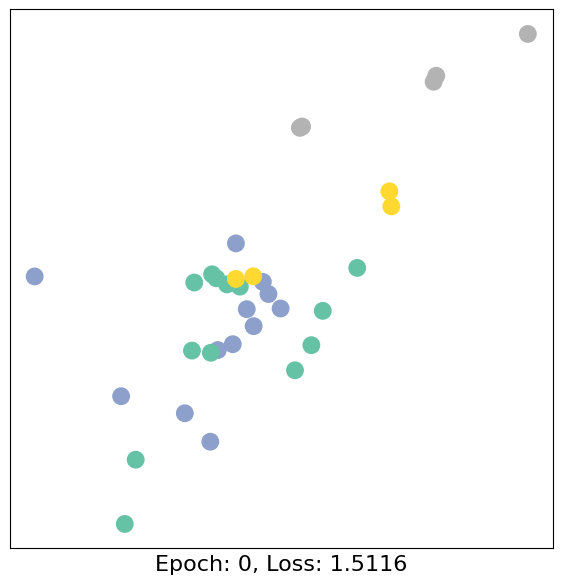

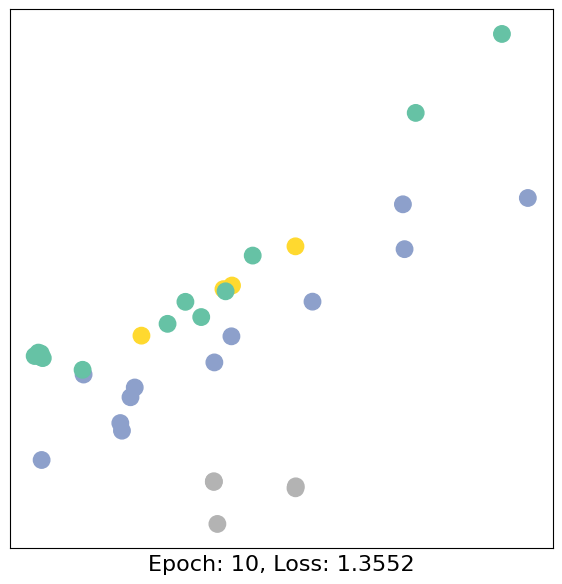

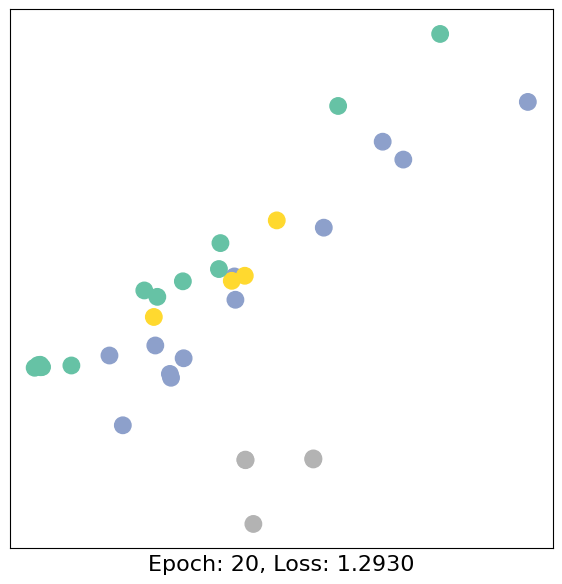

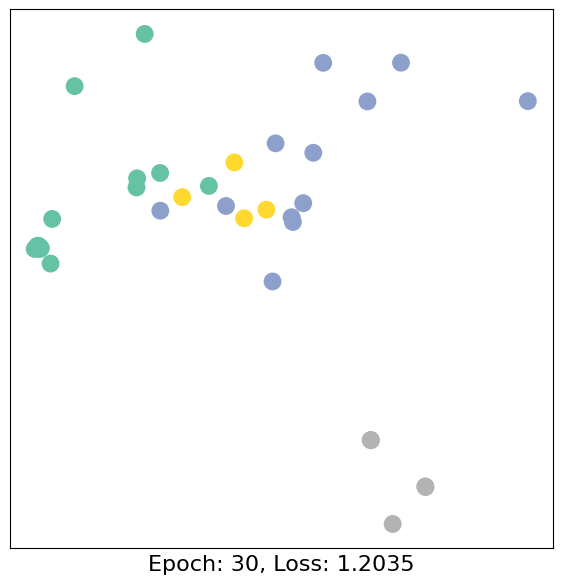

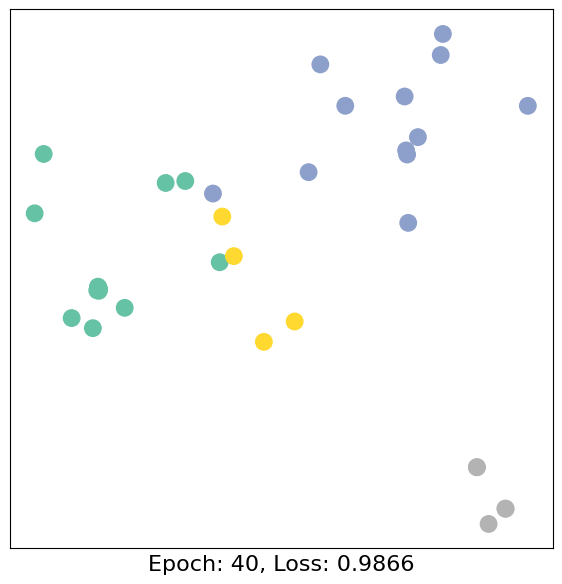

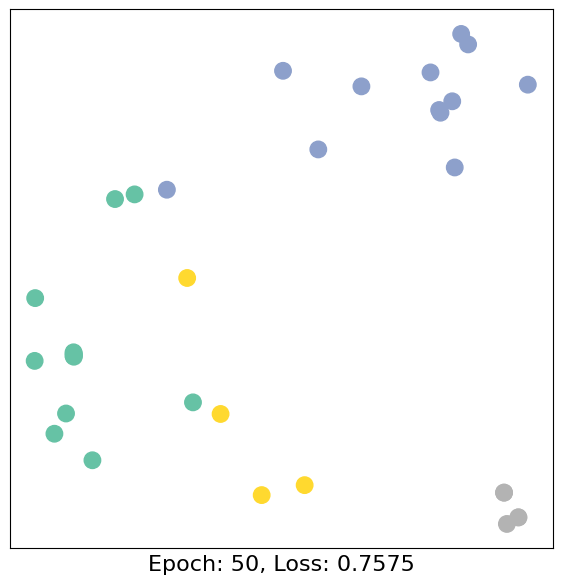

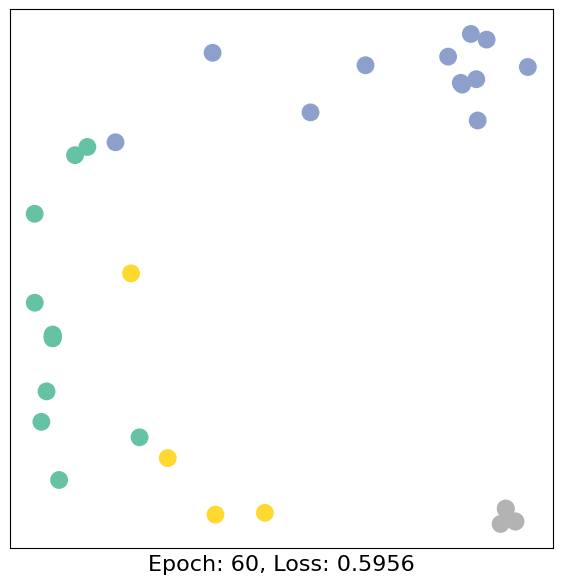

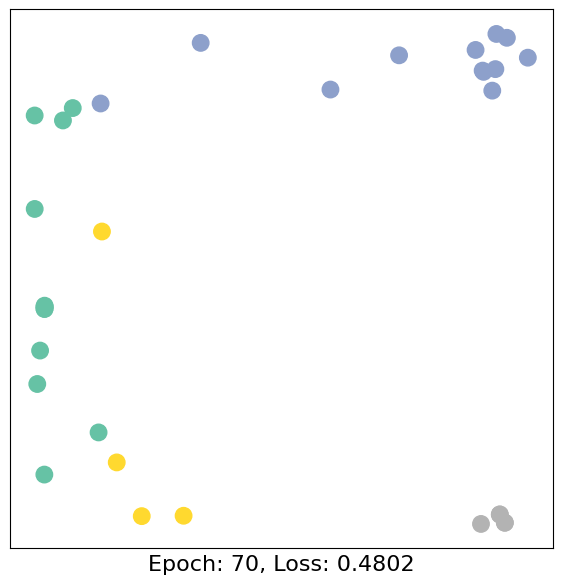

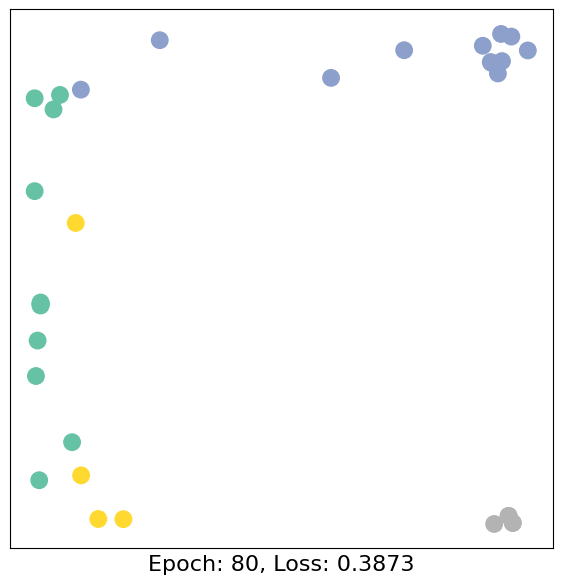

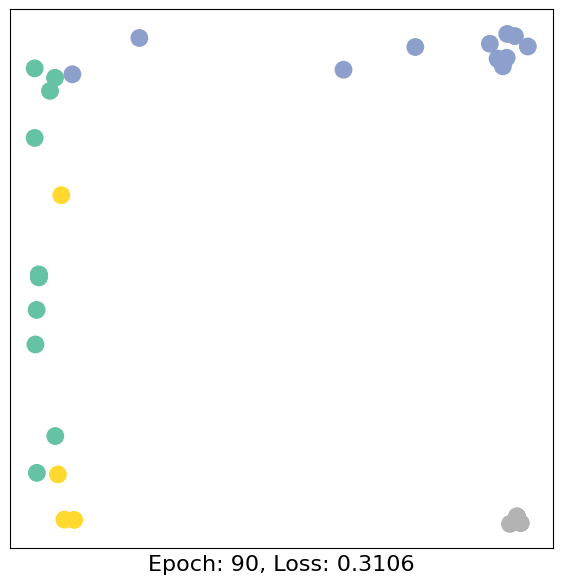

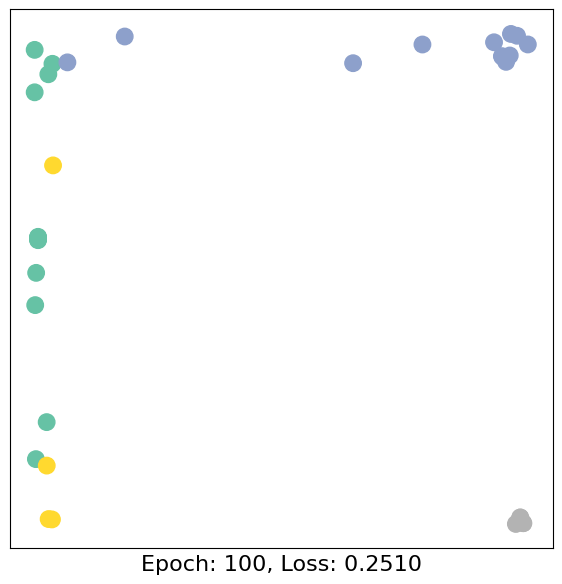

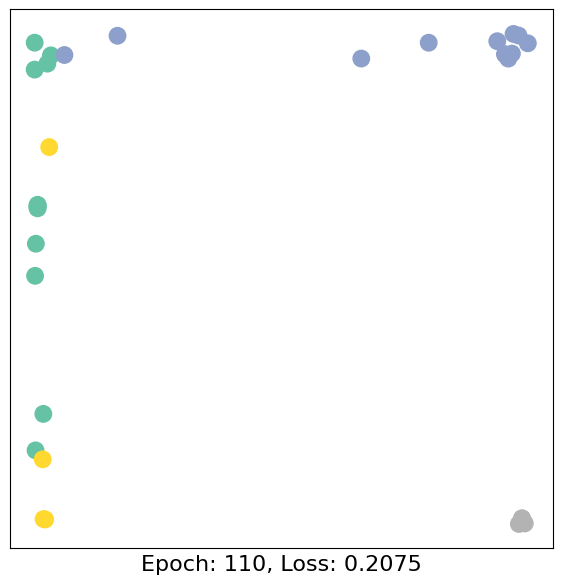

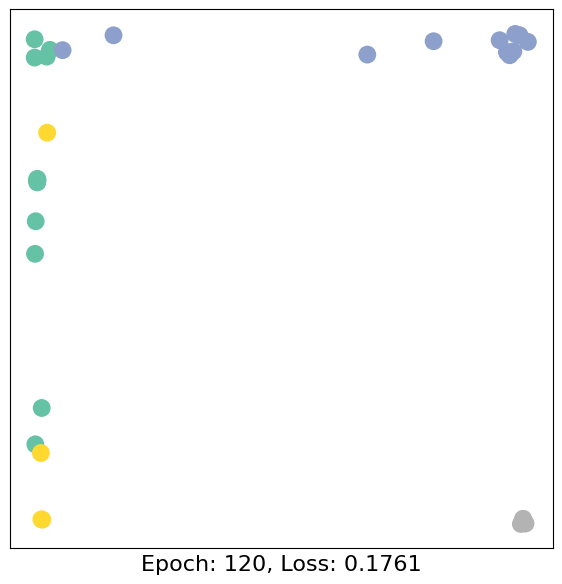

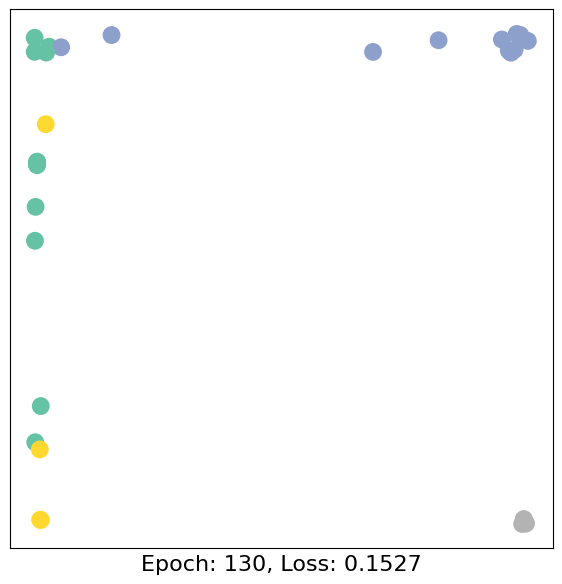

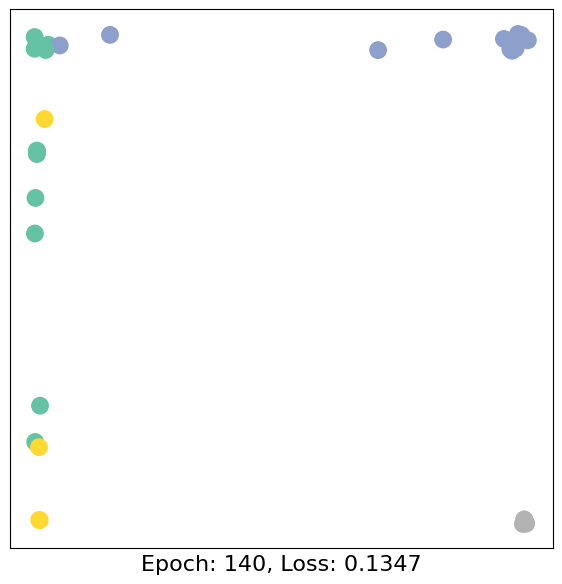

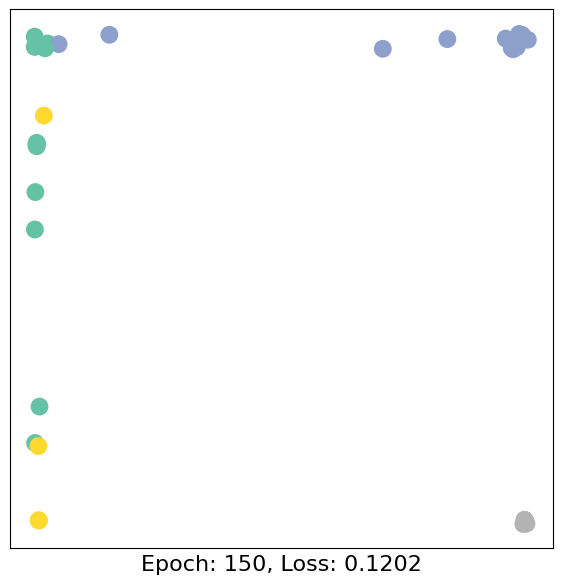

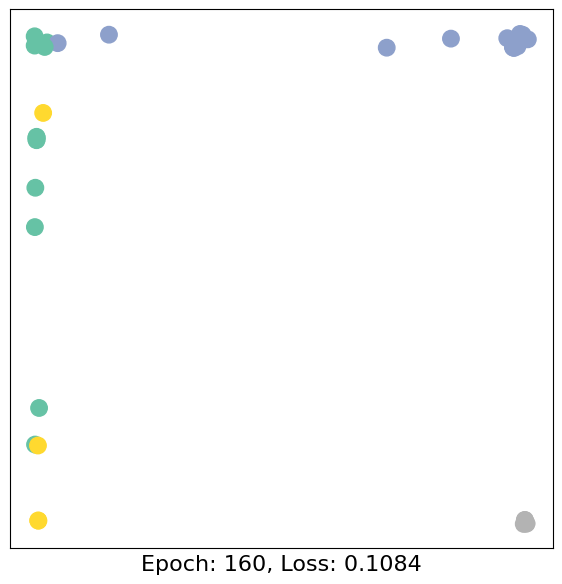

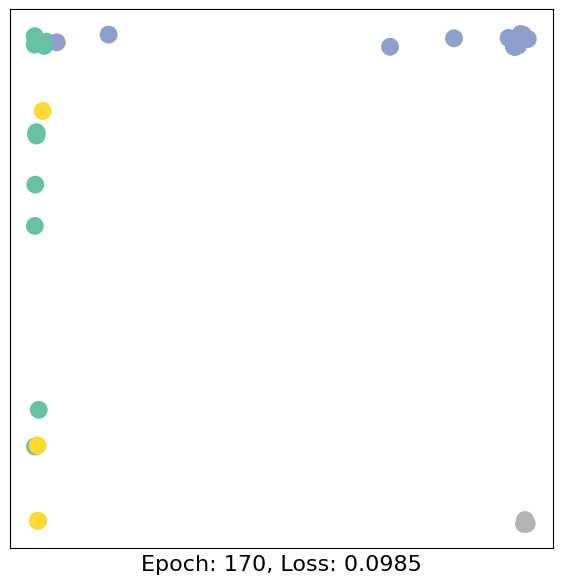

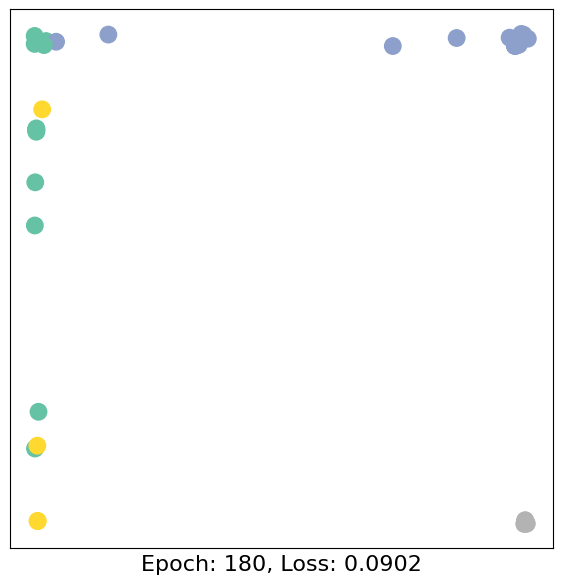

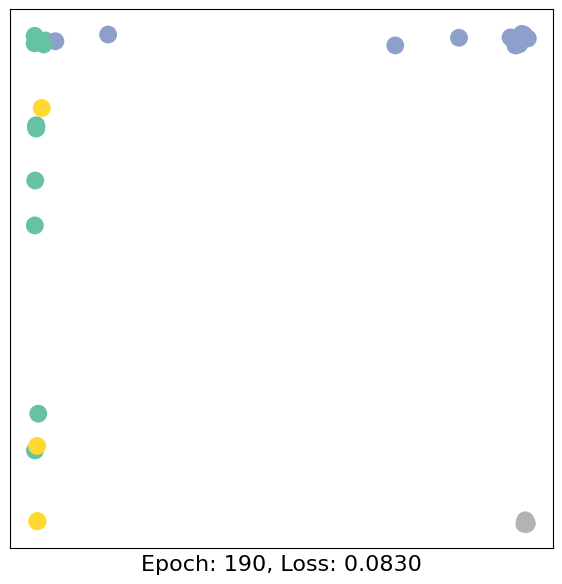

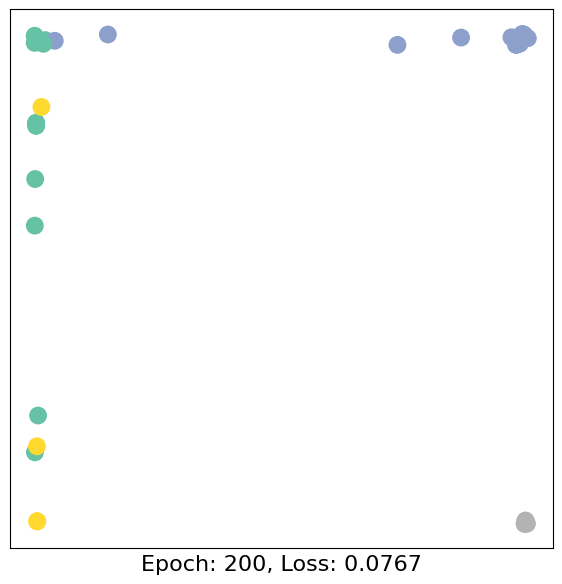

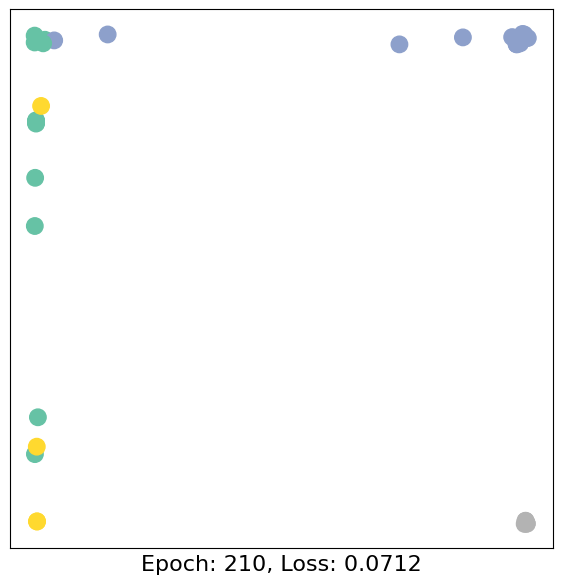

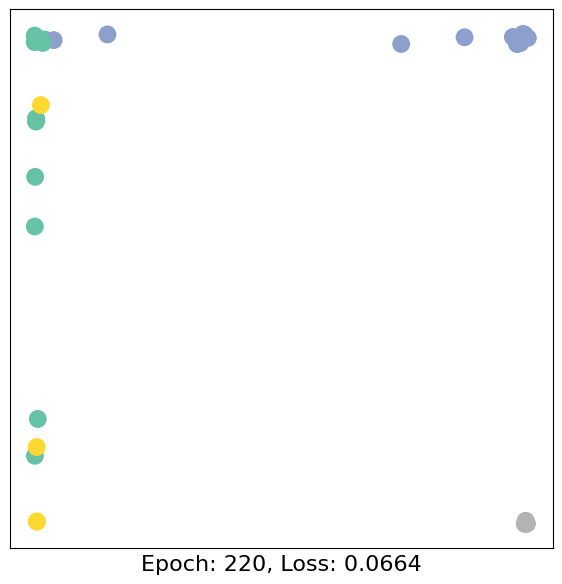

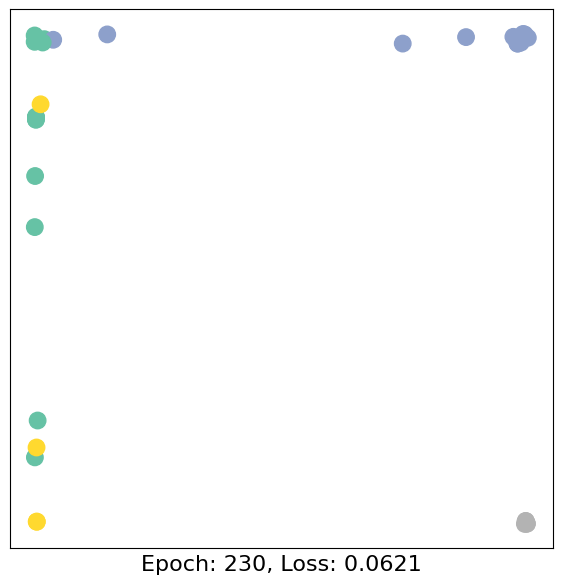

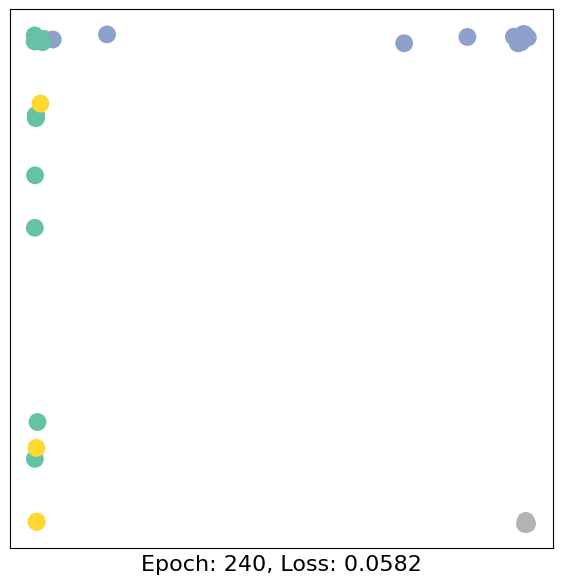

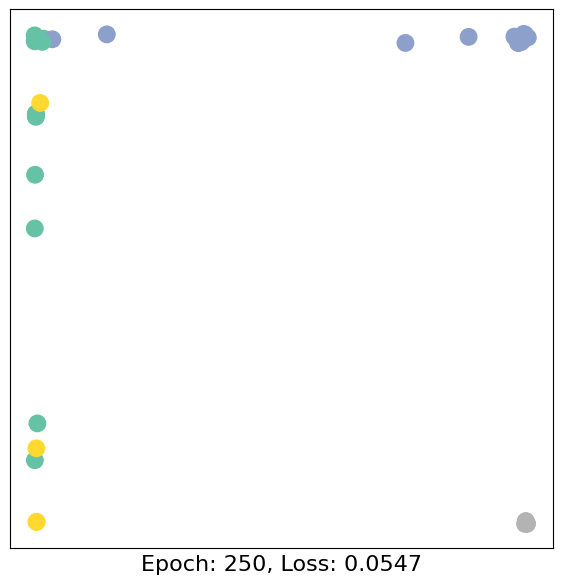

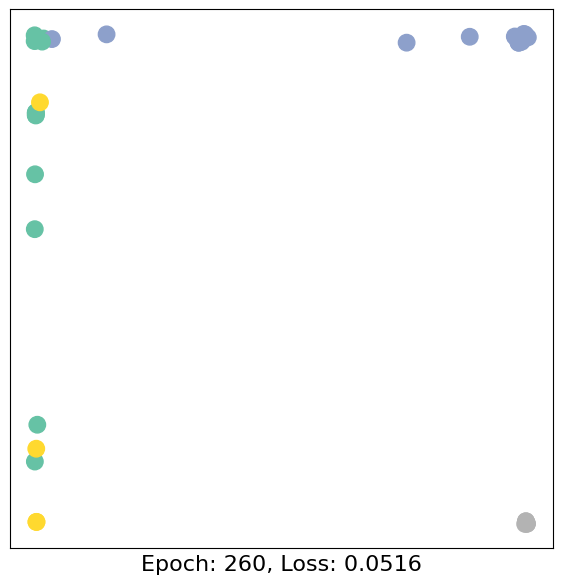

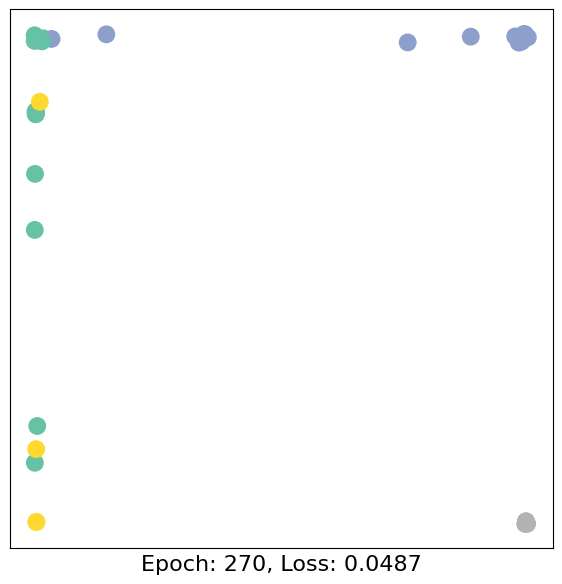

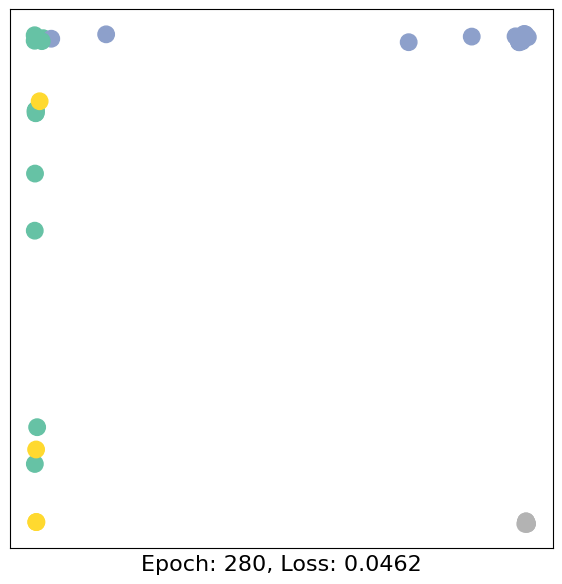

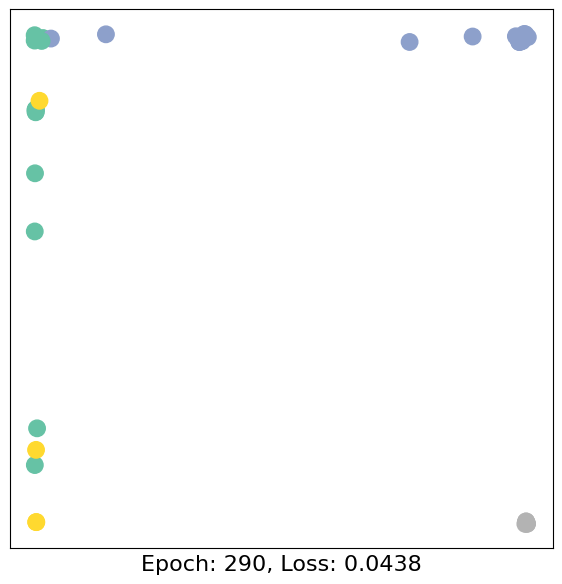

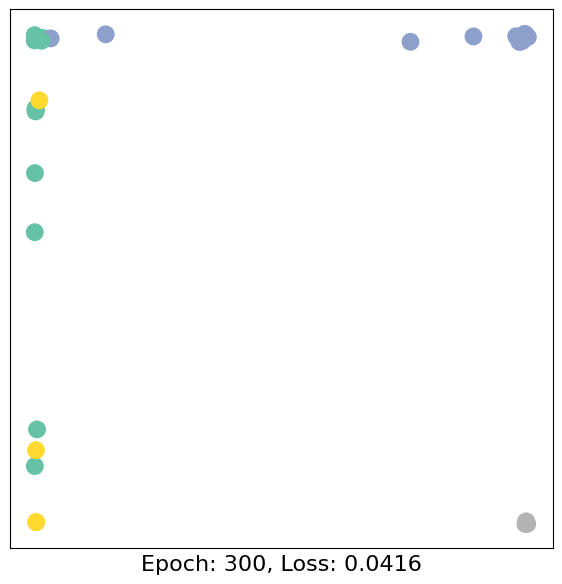

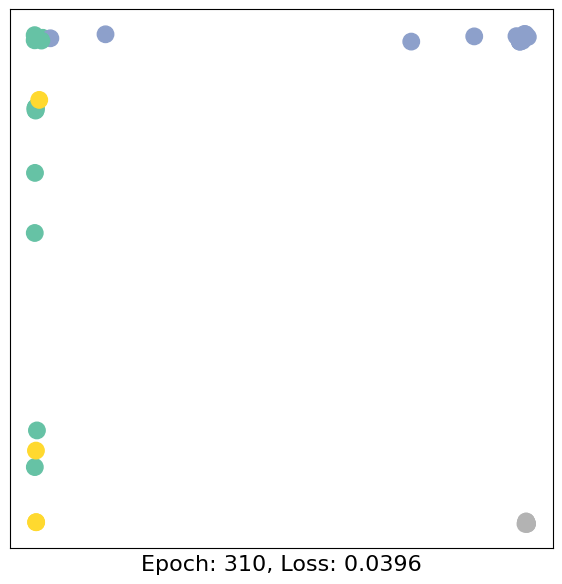

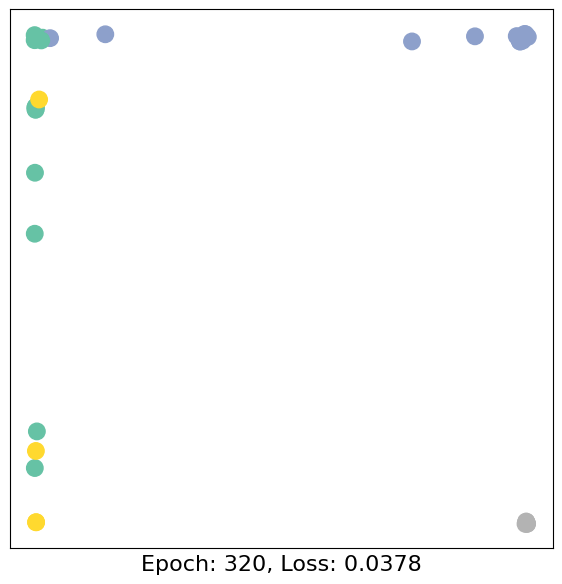

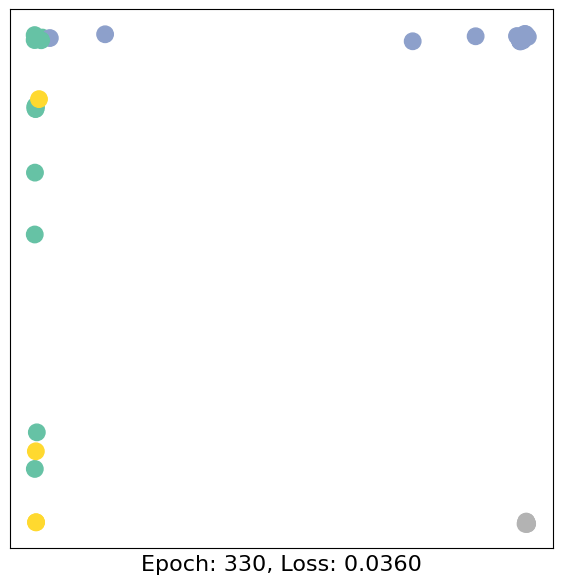

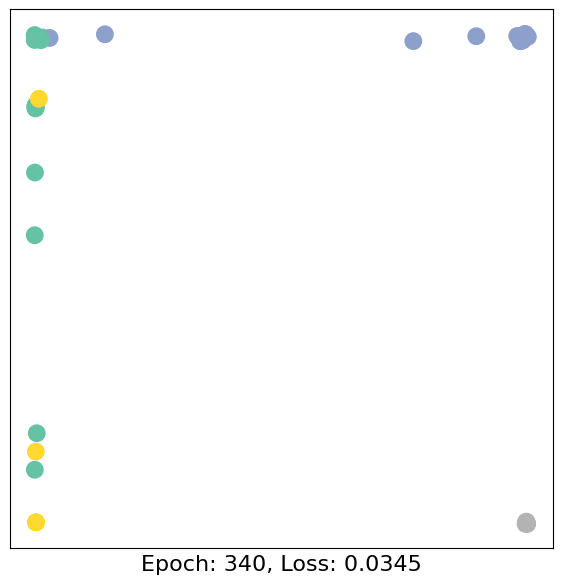

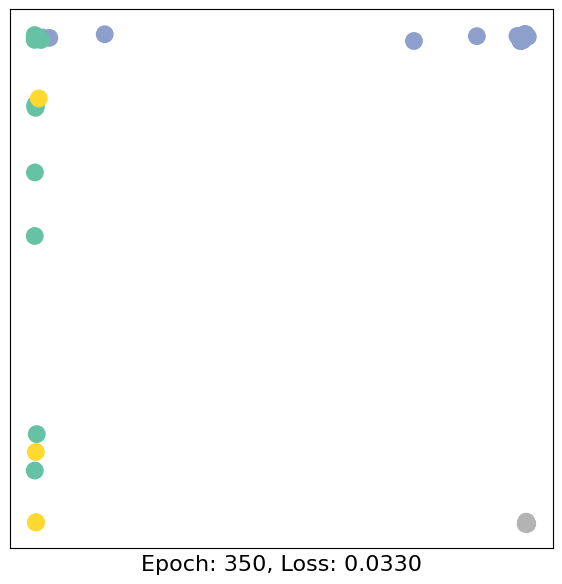

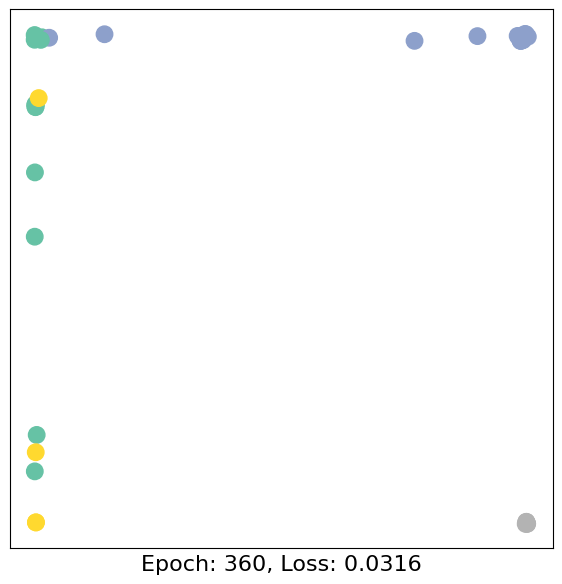

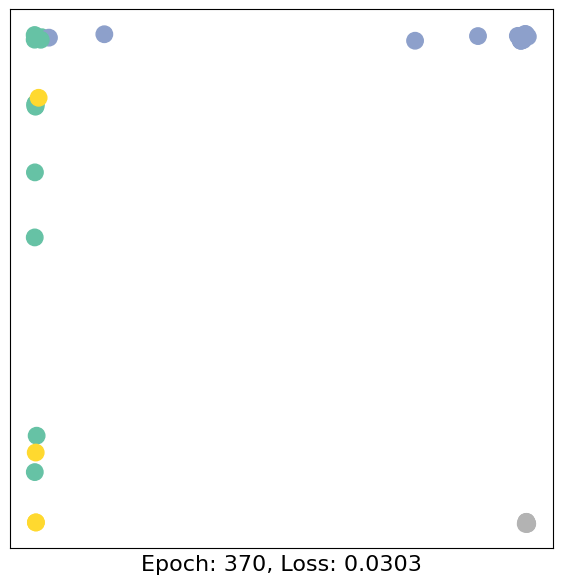

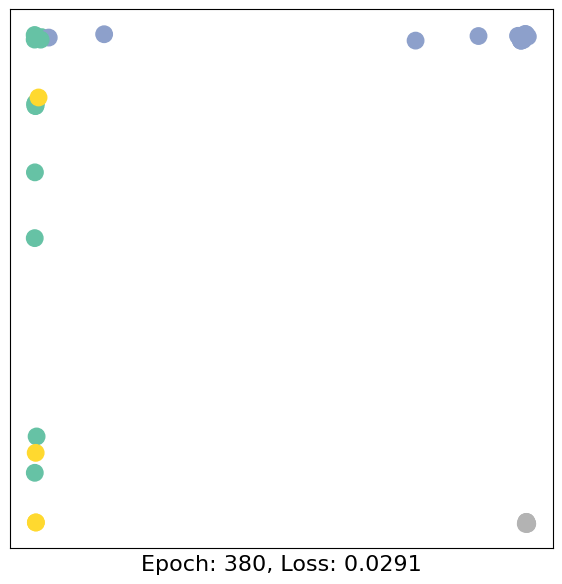

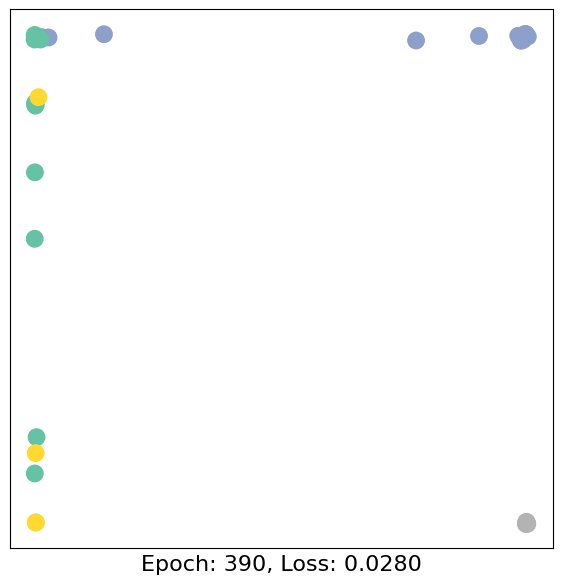

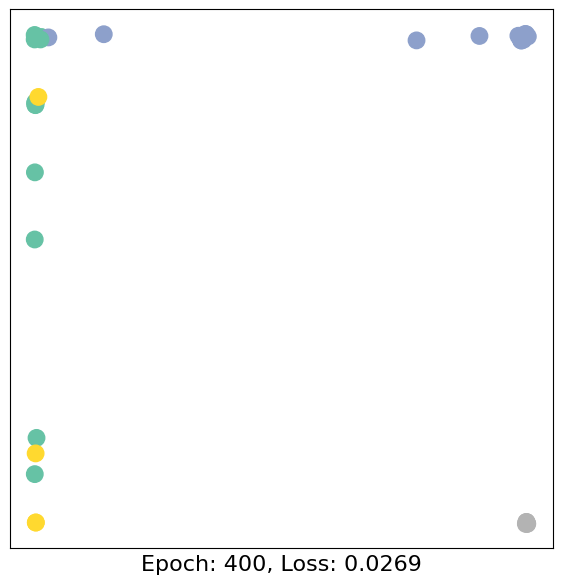

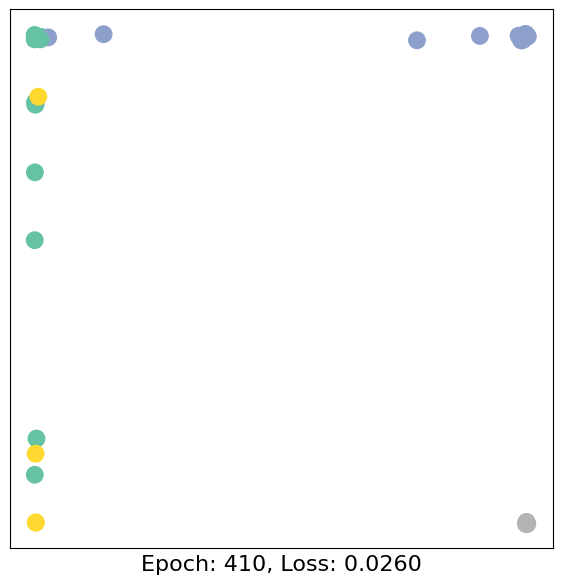

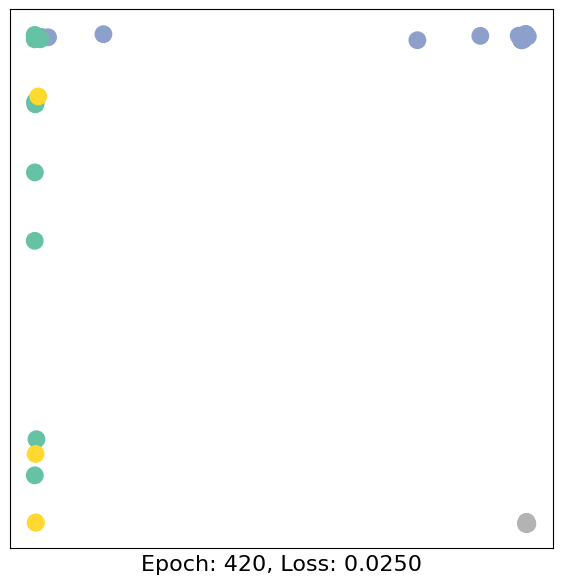

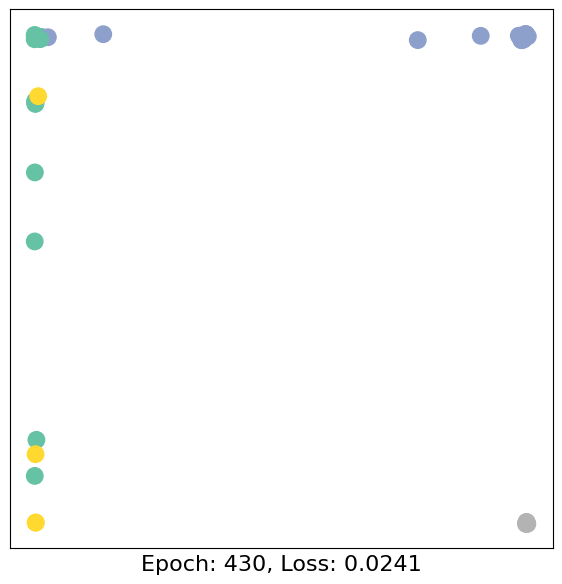

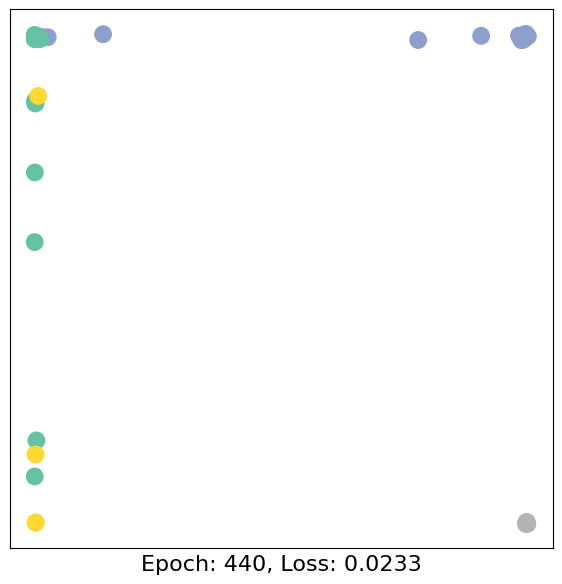

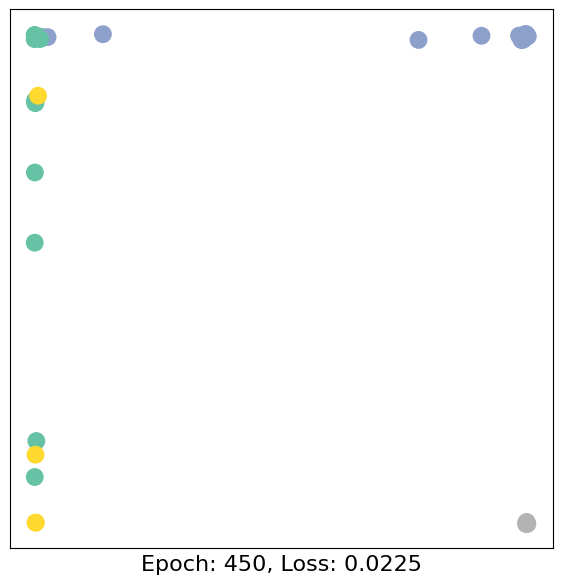

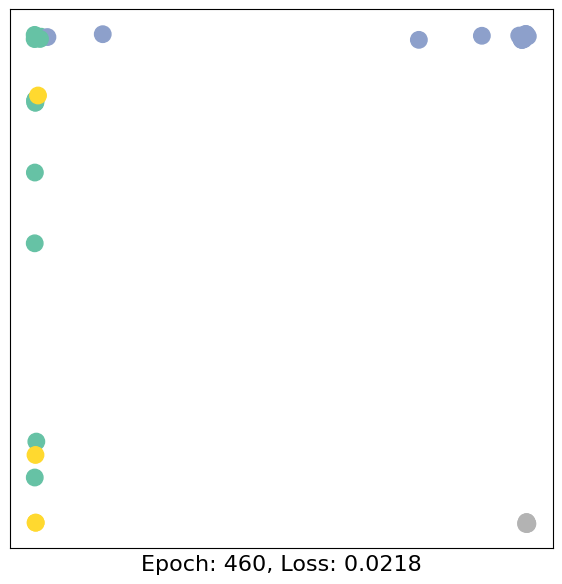

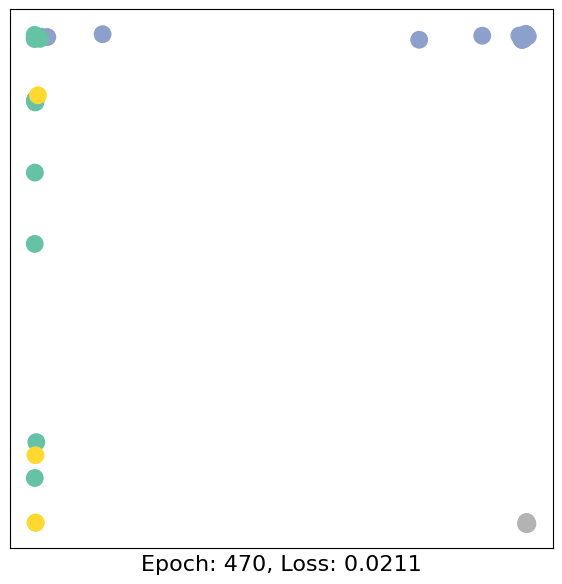

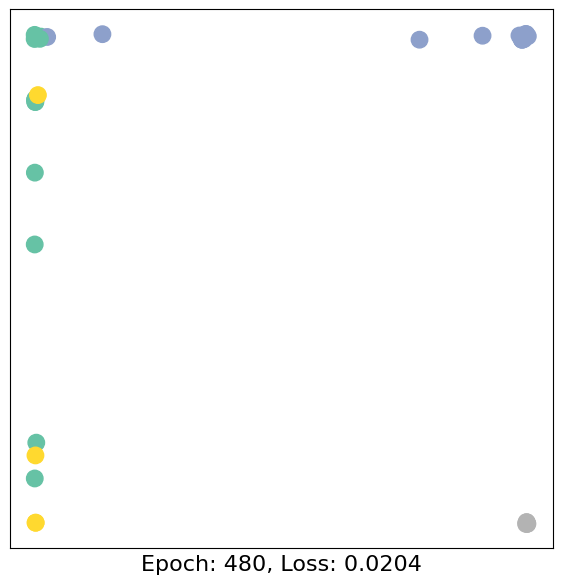

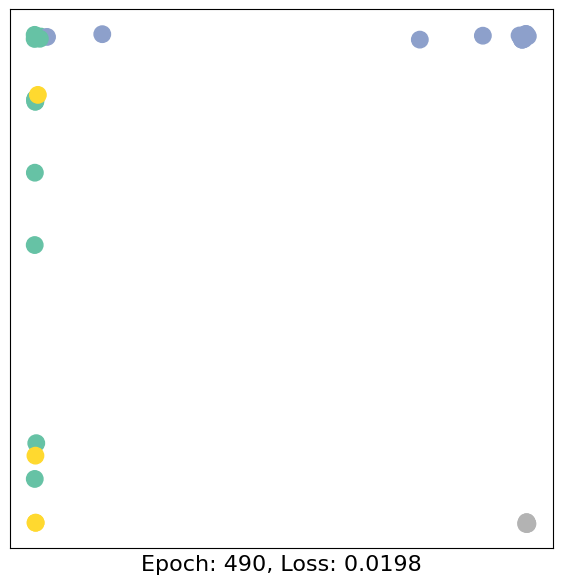

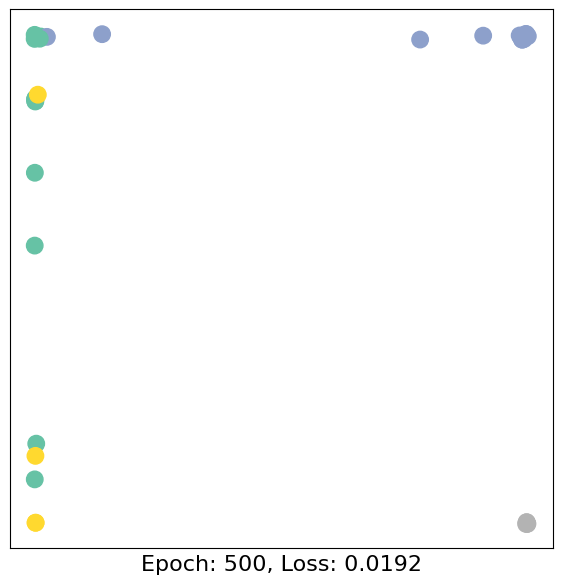

In [ ]:
import time
from IPython.display import Javascript
#Dla czytelności wyświetlania wyniku wysokość ramki Iframe jest ograniczana, będzie wymagała przewijania zawartości
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()  #wyzerowanie gradientów
    out, h = model(data.x, data.edge_index)  #przebieg "wprzód"
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  #strata loss obliczana wyłącznie na węzłach ze zbioru uczącego
    loss.backward()  #wyliczenie gradientów (wsteczna propagacja błędu)
    optimizer.step()  #aktualizacja trenowalnych wag modelu
    return loss, h

for epoch in range(501):
    loss, h = train(data)
    if epoch % 10 == 0: #jeśli co dziesiąta:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3) #bez pauzy zawodzi wyświetlanie...

In [ ]:
model.eval()
out, _ = model(data.x, data.edge_index)
out

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.83


Dodanie warstwy konwolucyjnej i zwiększenie liczby kanałów wejściowych i wyjściowych.
Poskutkowało to zwiększeniem accuracy do 83%.

Zwiększenie zbioru treningowego poprzez modyfikacje maski do dwóch przykładów dla każdej klasy.

In [ ]:
print(data.y)
data.train_mask[7]=False
data.train_mask[2]=True
data.train_mask[6]=True
data.train_mask[33]=True
data.train_mask[31]=True
print(data.train_mask)

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
tensor([ True, False,  True, False,  True, False,  True, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True, False,  True])


<IPython.core.display.Javascript object>

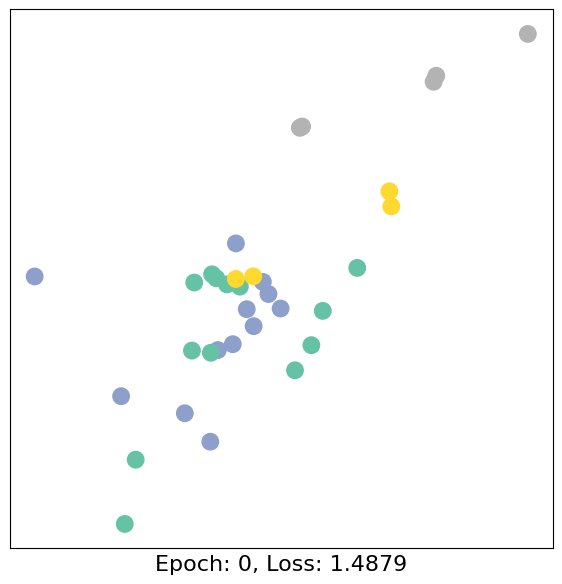

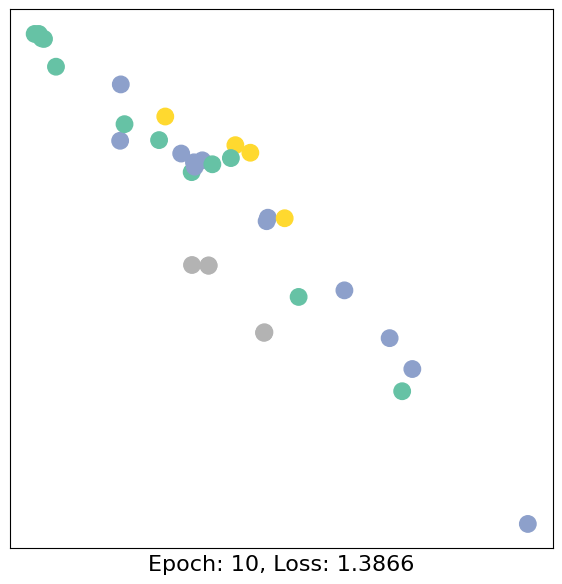

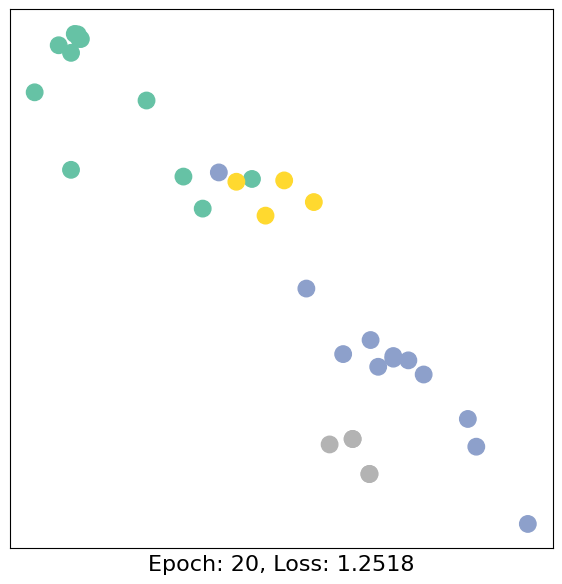

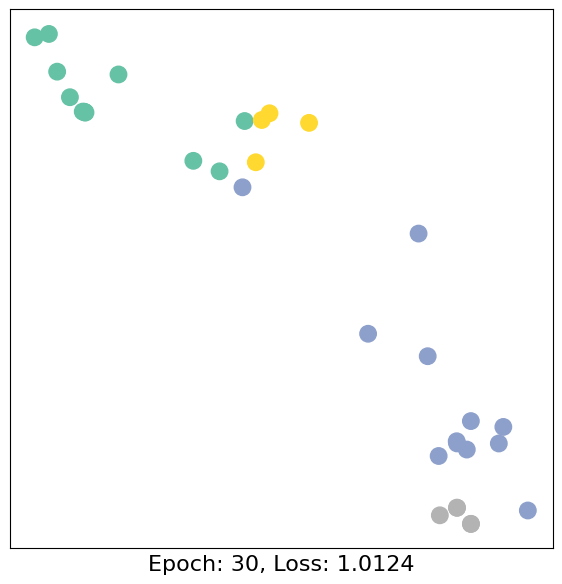

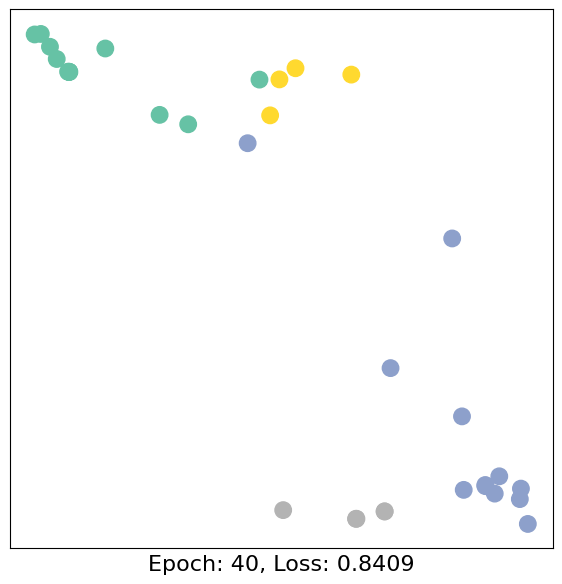

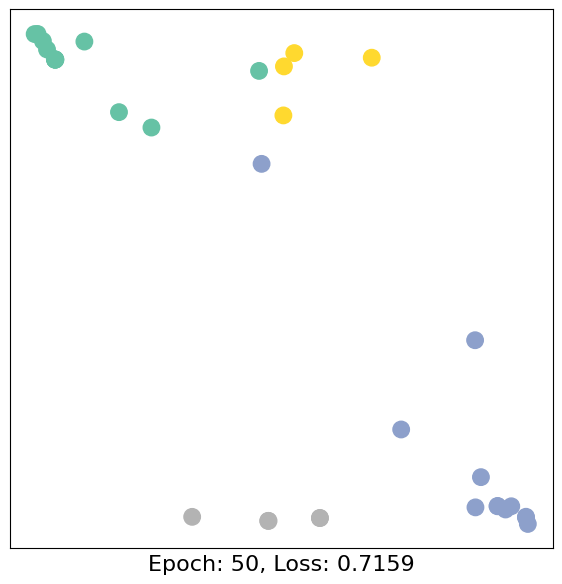

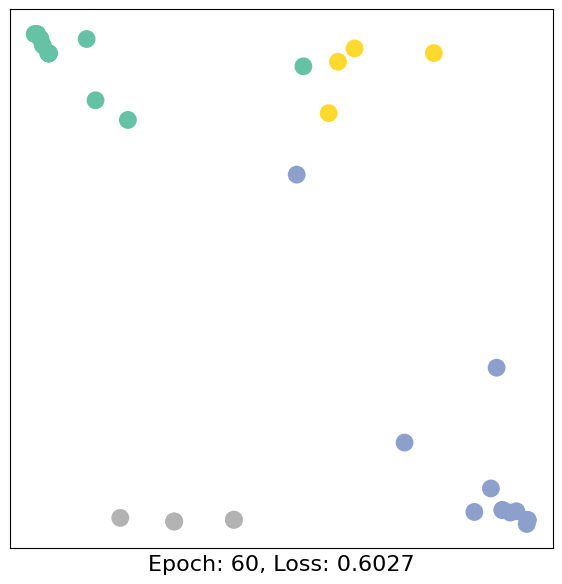

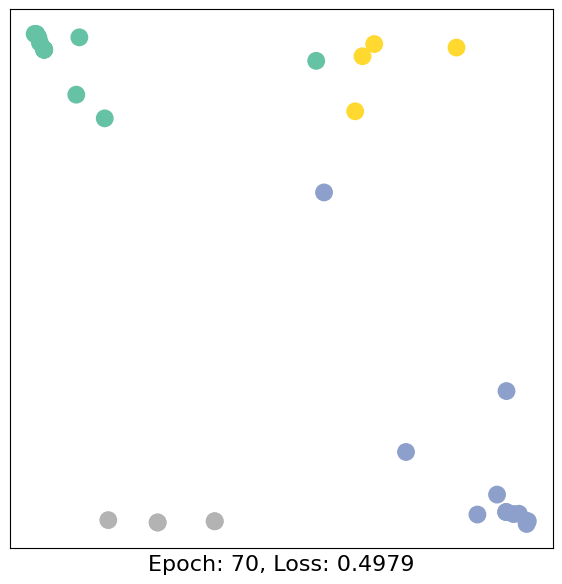

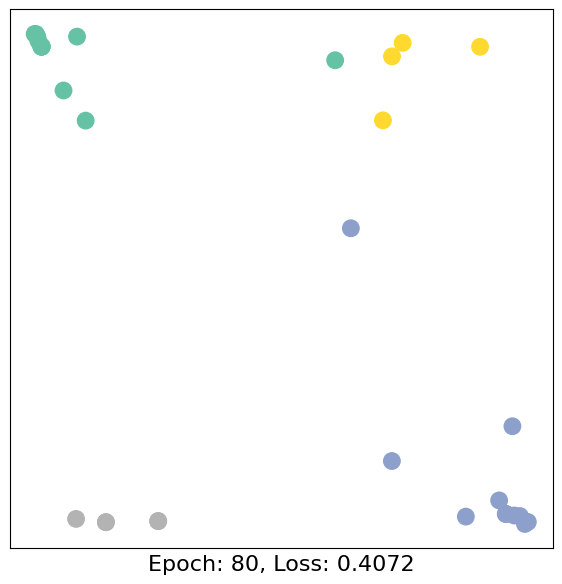

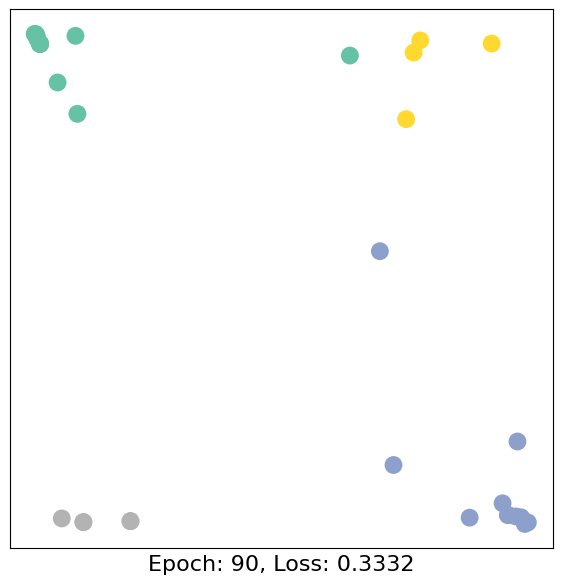

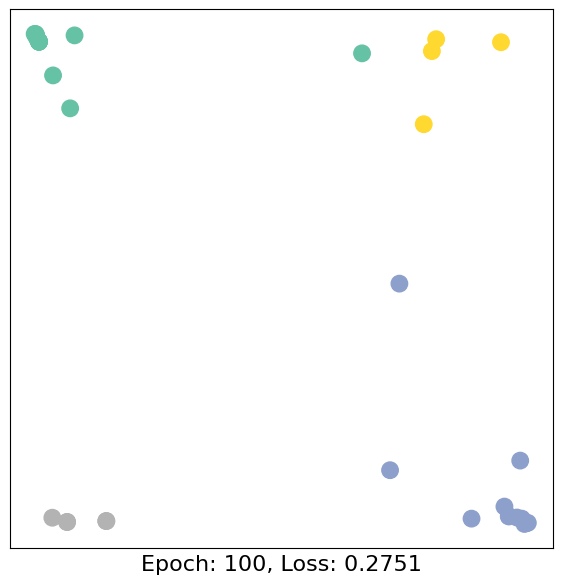

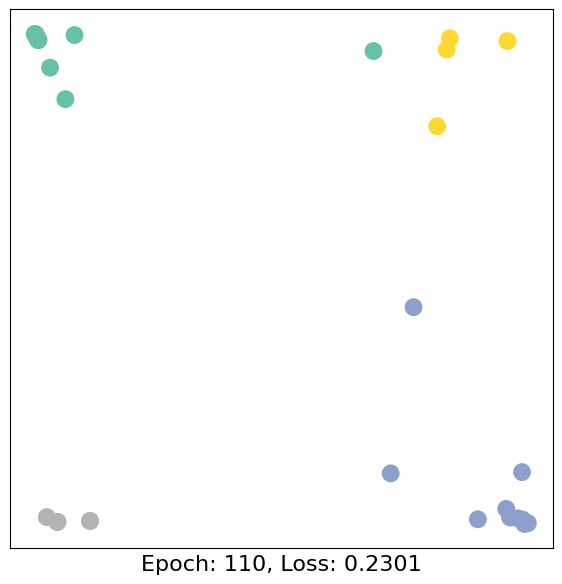

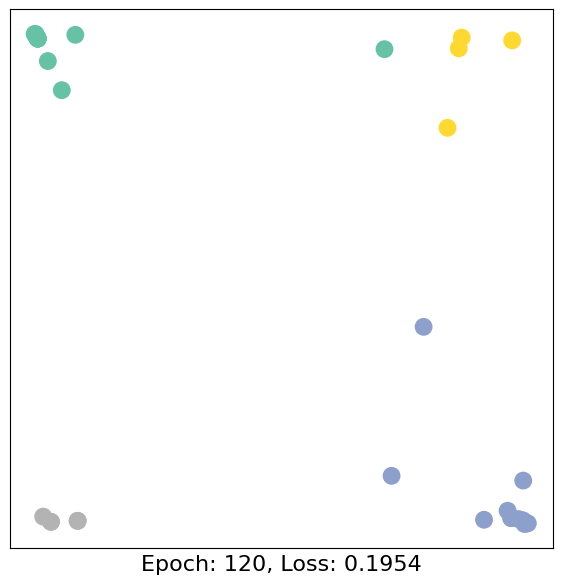

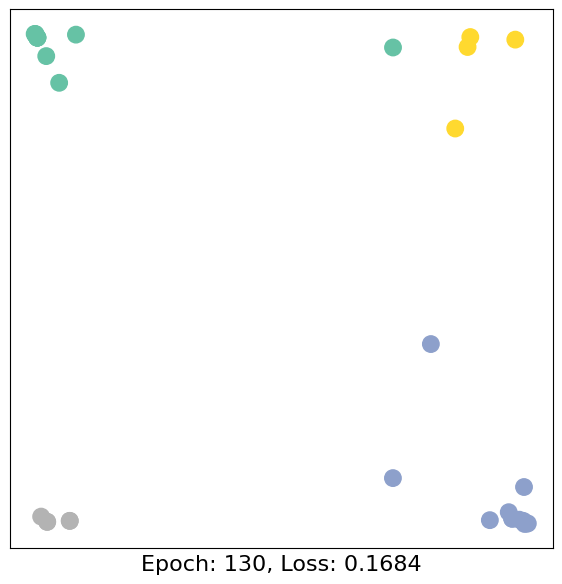

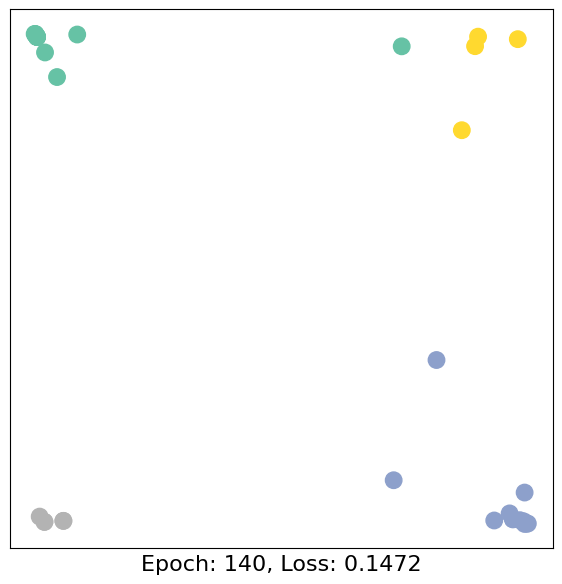

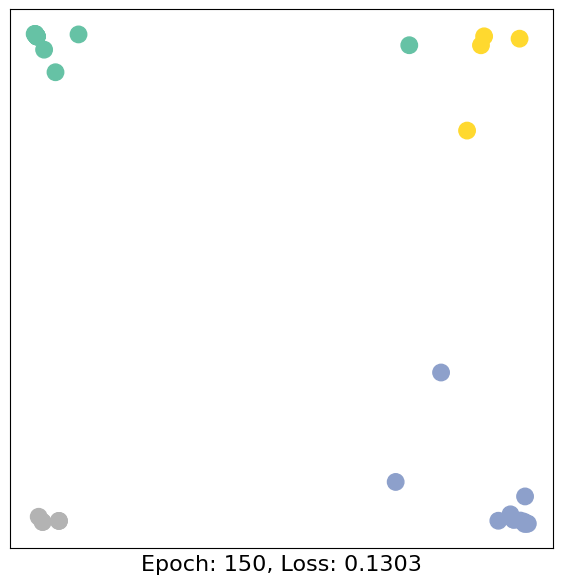

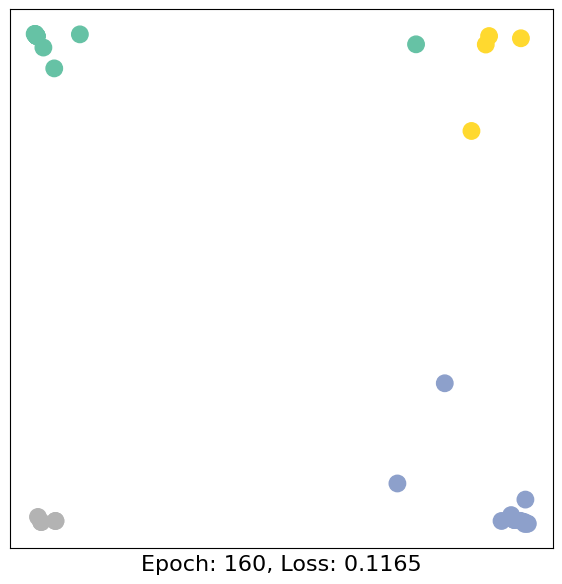

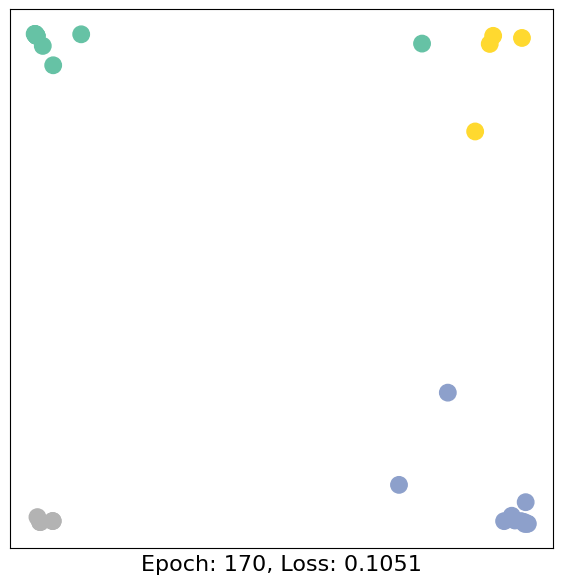

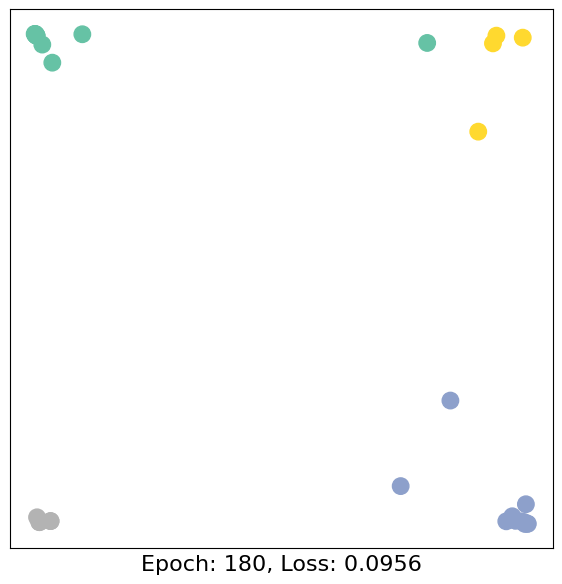

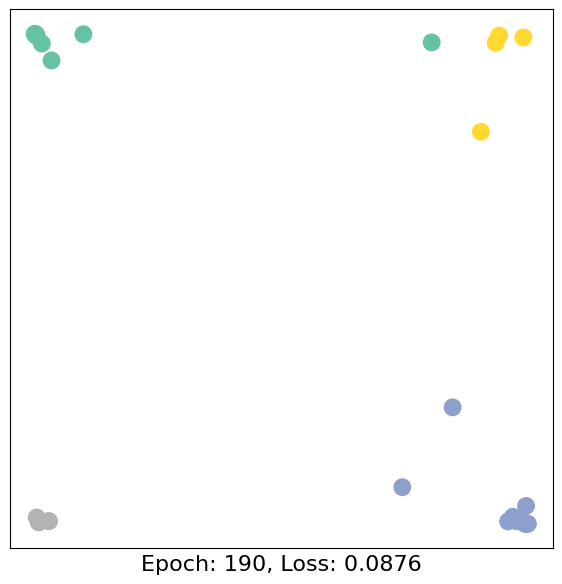

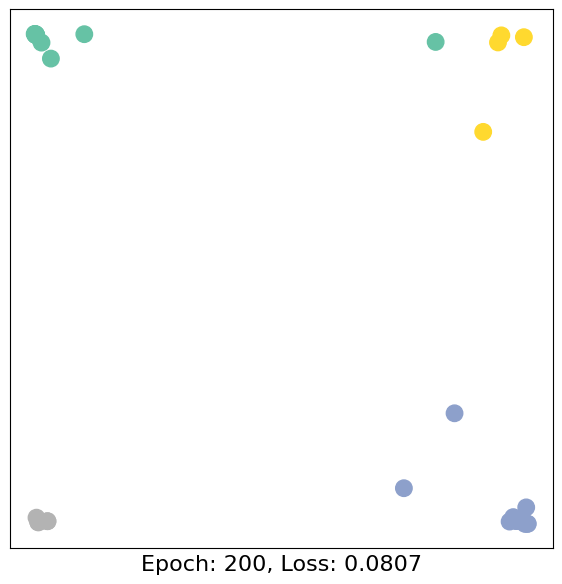

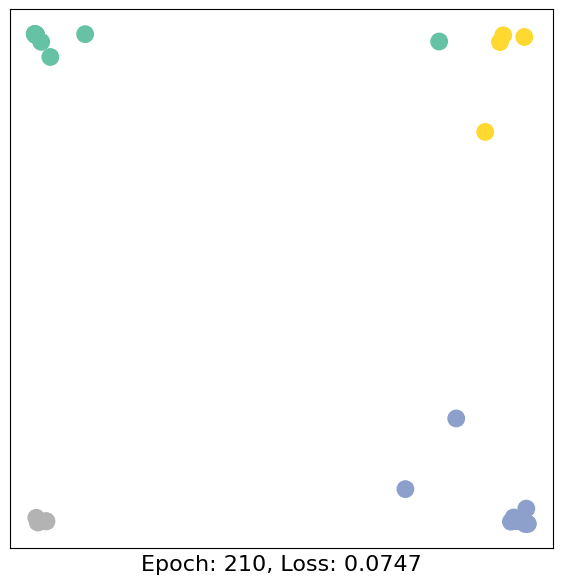

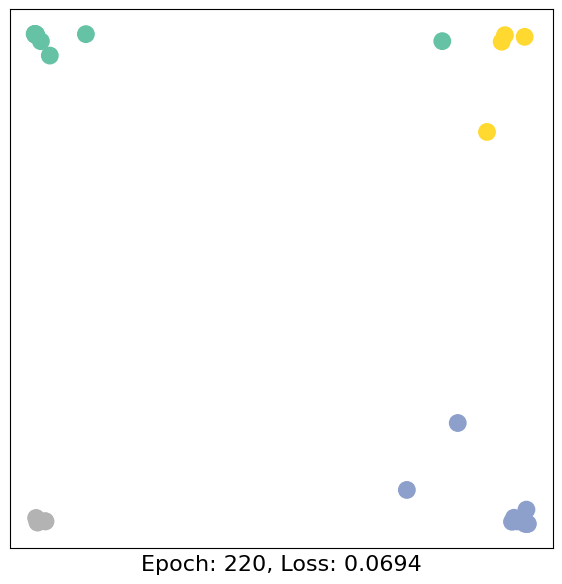

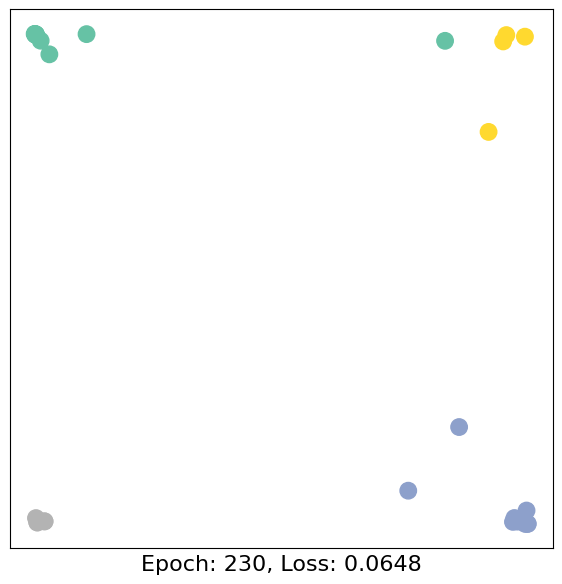

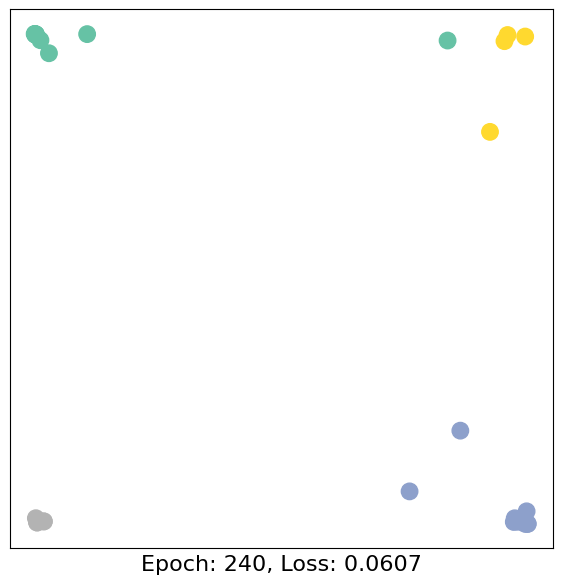

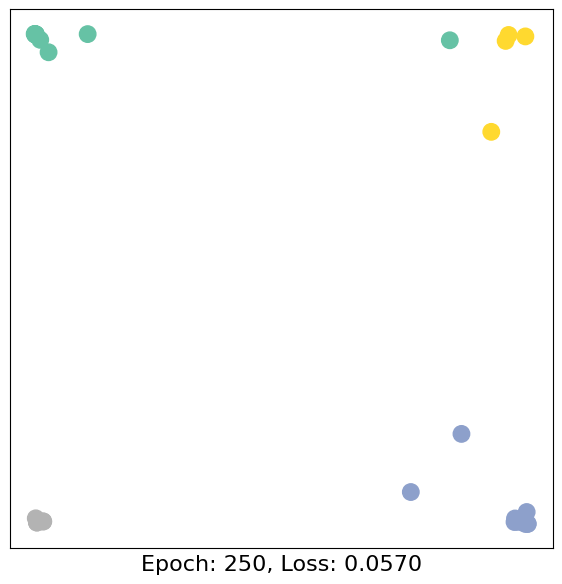

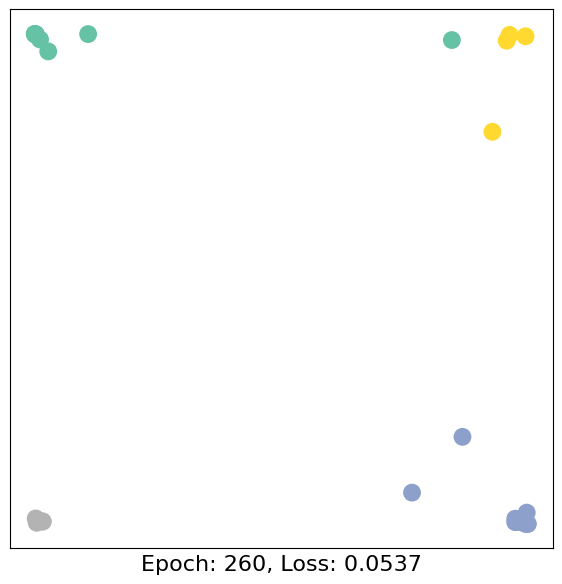

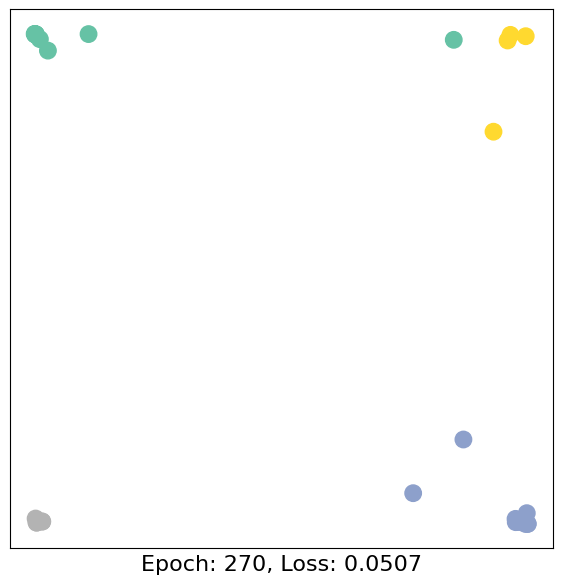

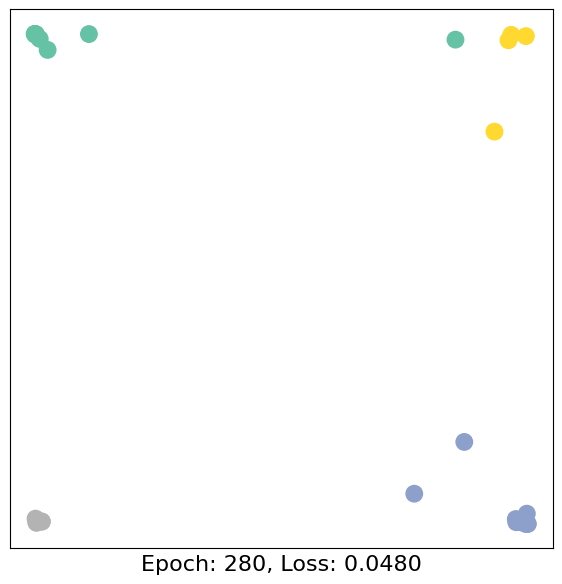

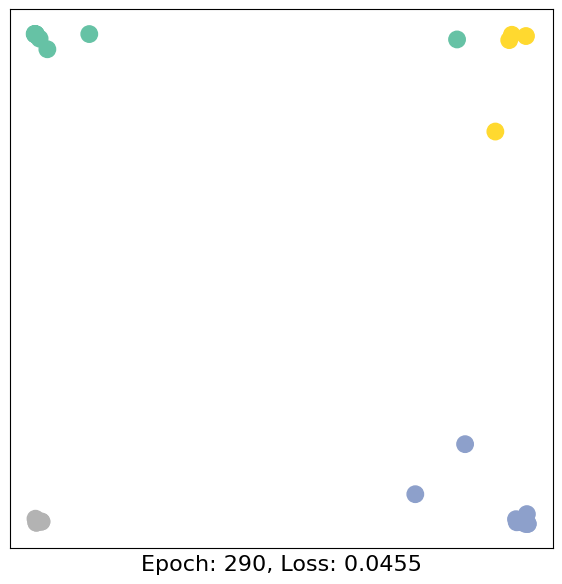

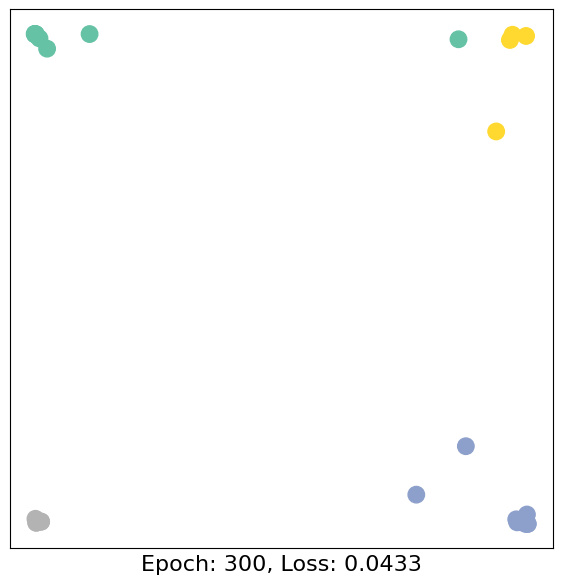

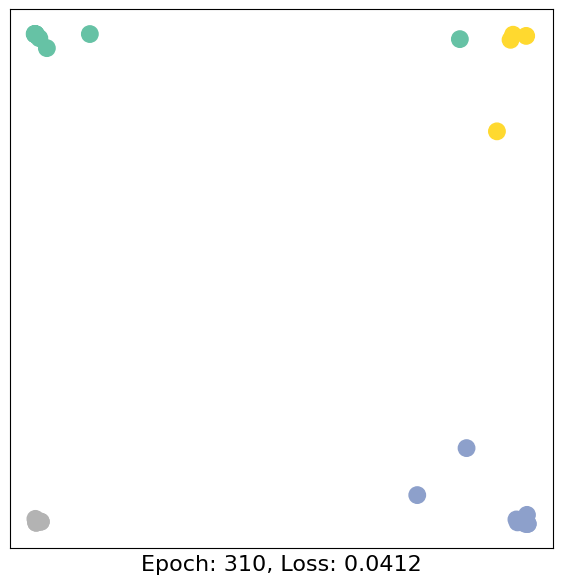

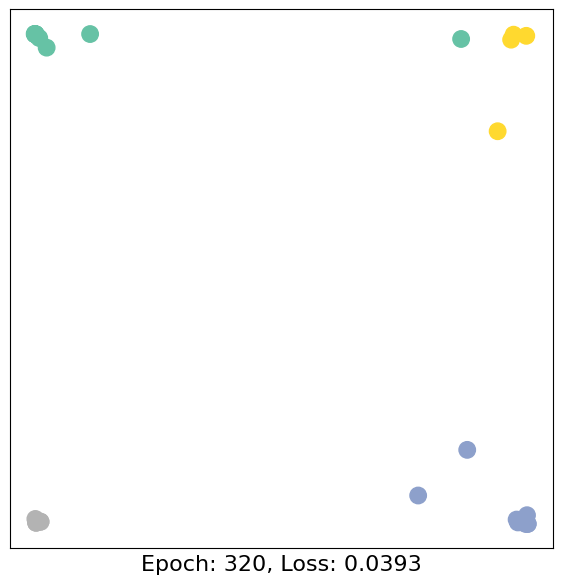

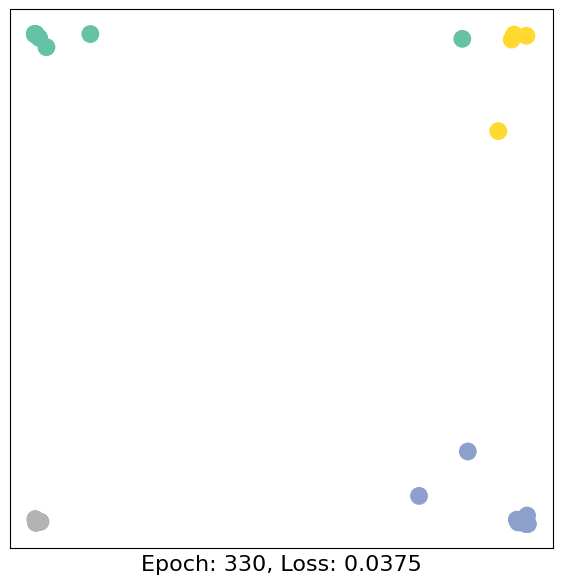

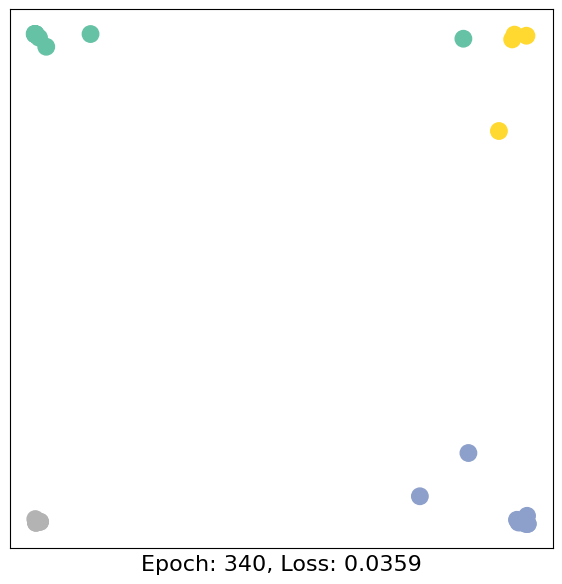

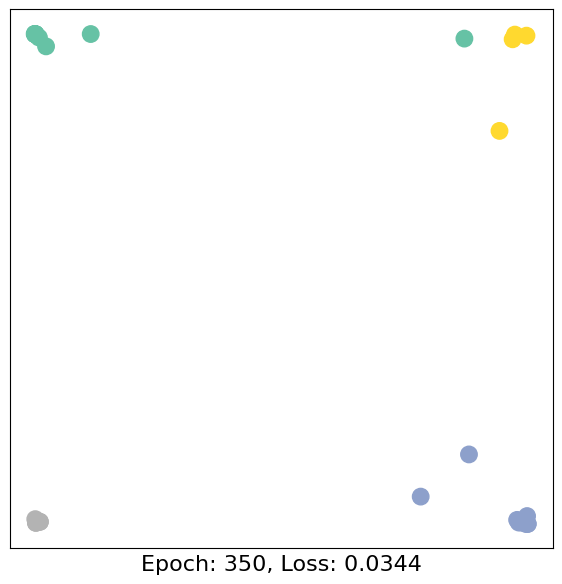

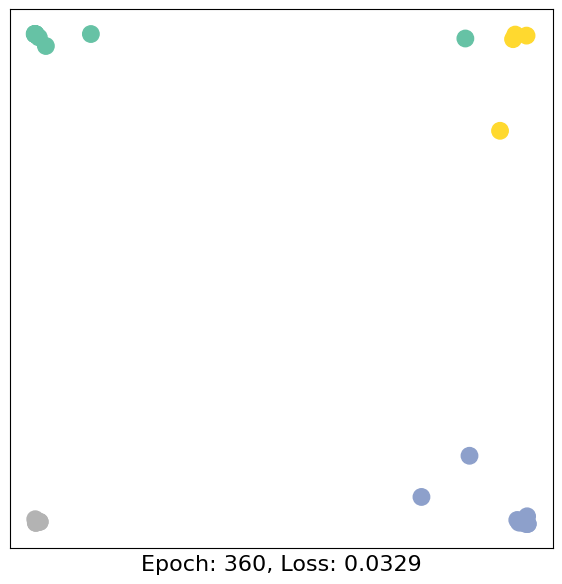

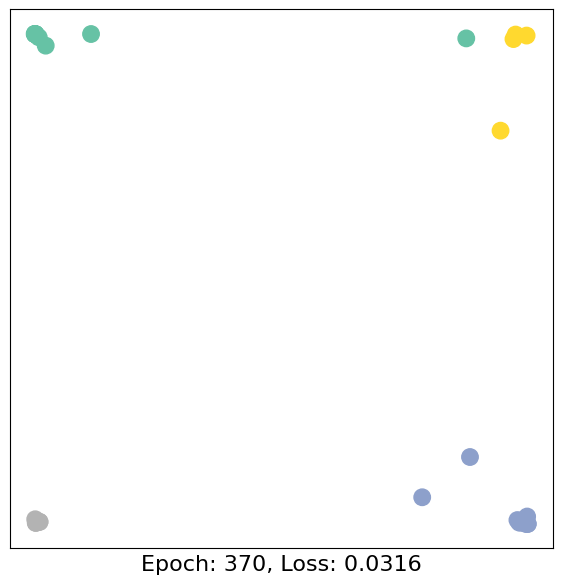

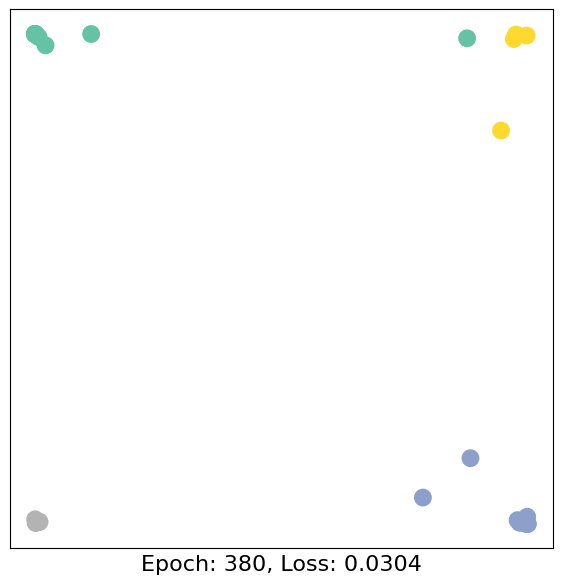

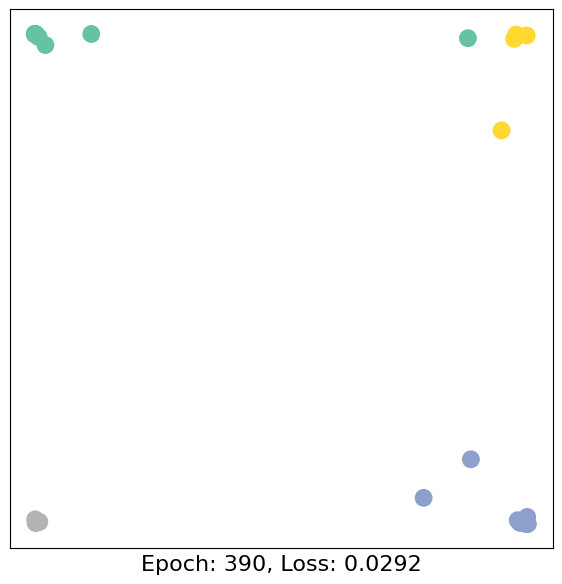

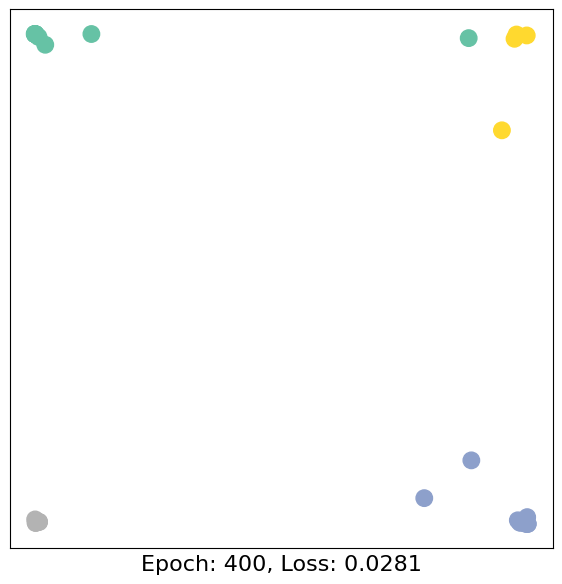

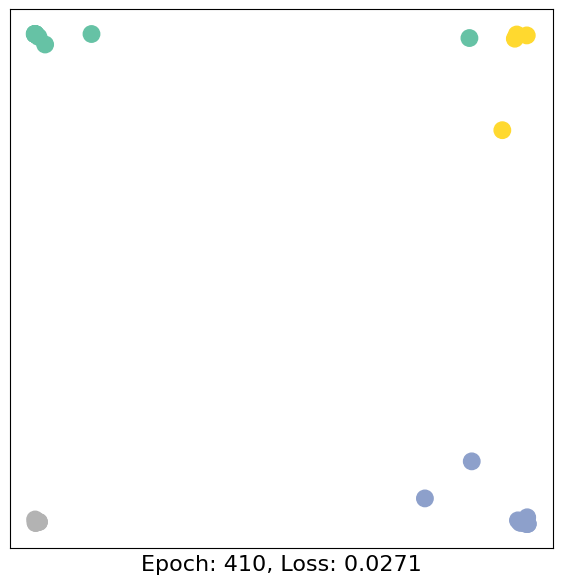

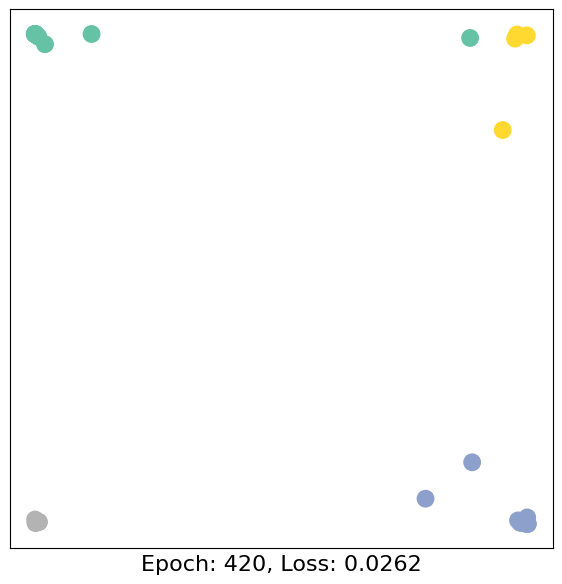

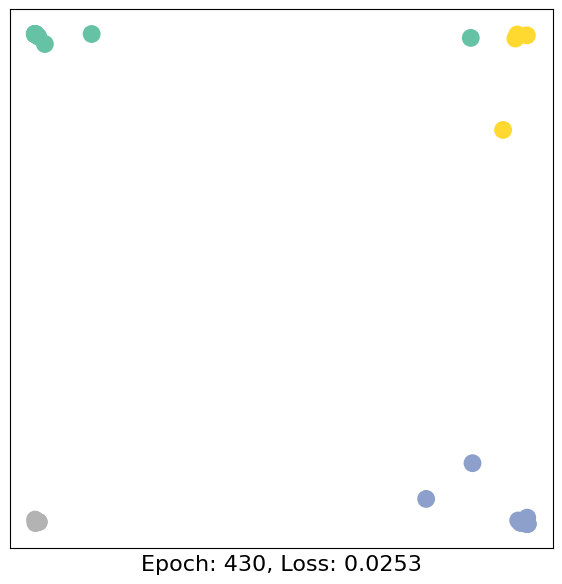

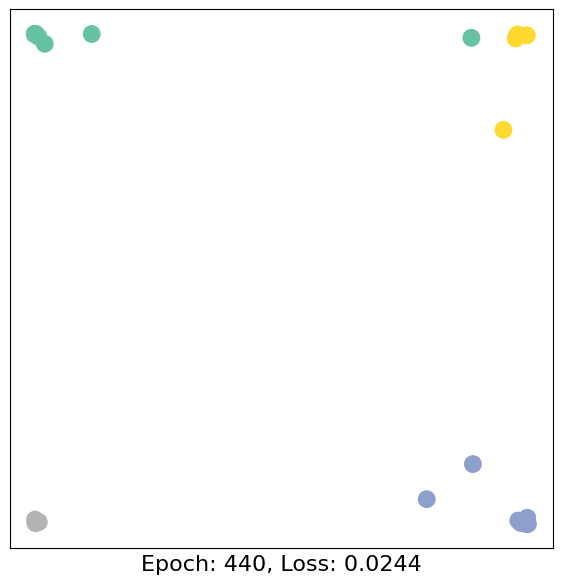

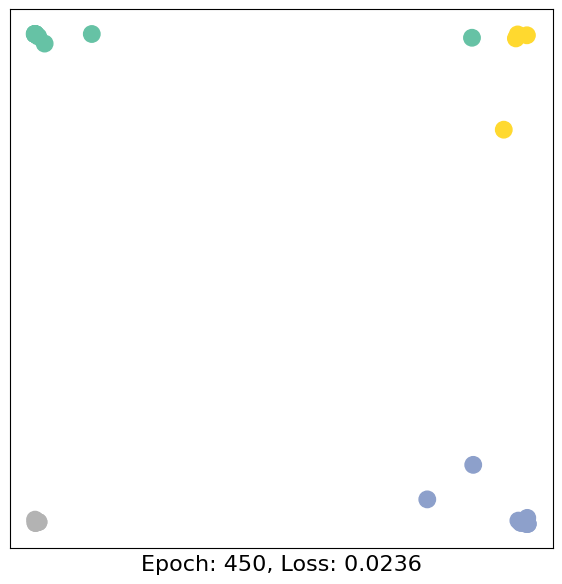

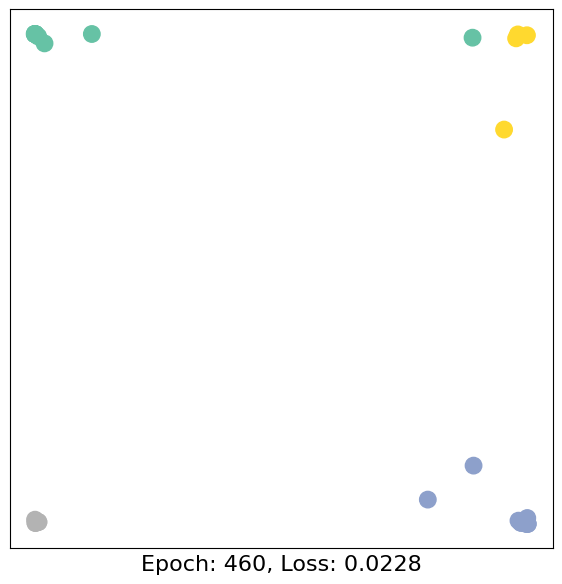

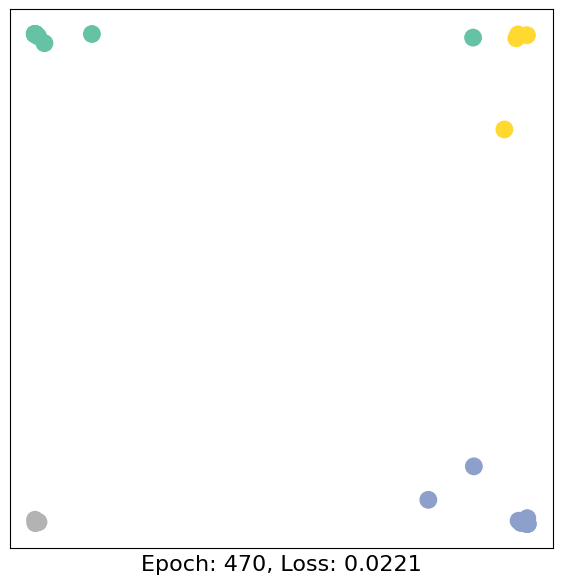

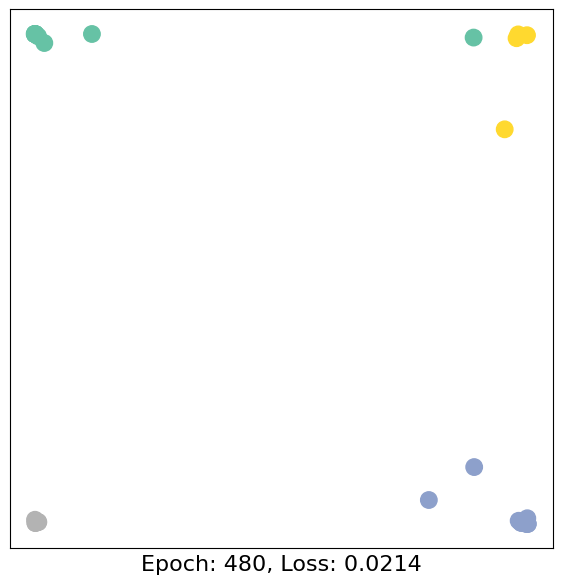

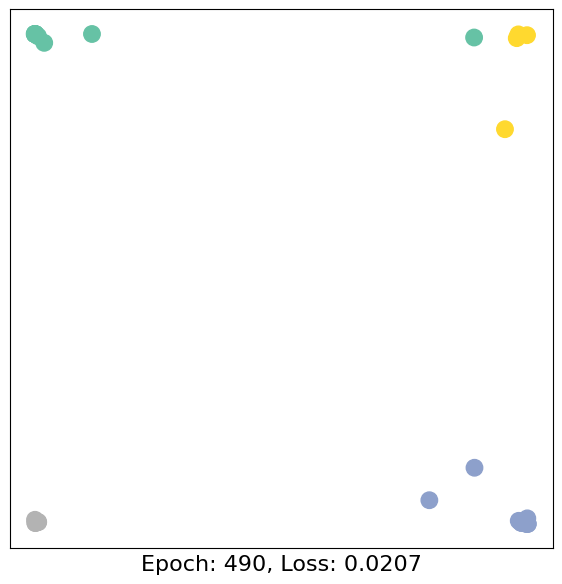

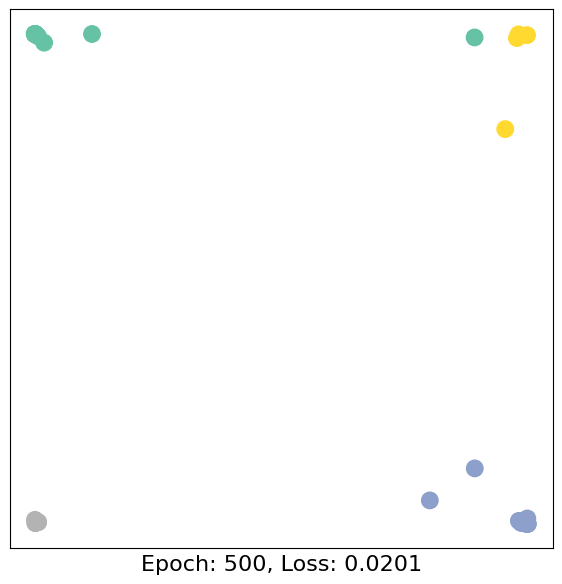

In [ ]:
import time
from IPython.display import Javascript
#Dla czytelności wyświetlania wyniku wysokość ramki Iframe jest ograniczana, będzie wymagała przewijania zawartości
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()  #wyzerowanie gradientów
    out, h = model(data.x, data.edge_index)  #przebieg "wprzód"
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  #strata loss obliczana wyłącznie na węzłach ze zbioru uczącego
    loss.backward()  #wyliczenie gradientów (wsteczna propagacja błędu)
    optimizer.step()  #aktualizacja trenowalnych wag modelu
    return loss, h

for epoch in range(501):
    loss, h = train(data)
    if epoch % 10 == 0: #jeśli co dziesiąta:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3) #bez pauzy zawodzi wyświetlanie...

In [ ]:
model.eval()
out, _ = model(data.x, data.edge_index)
out

tensor([[-5.2199,  4.7180,  0.0461,  0.1700],
        [-5.2347,  4.7336,  0.0599,  0.1574],
        [-5.1721,  4.6819,  0.1106,  0.1152],
        [-5.2364,  4.7355,  0.0616,  0.1558],
        [-0.2881, -0.4863, -4.3602,  4.2089],
        [-0.2711, -0.5068, -4.3938,  4.2390],
        [-0.2712, -0.5067, -4.3938,  4.2390],
        [-5.2153,  4.7144,  0.0512,  0.1657],
        [ 4.8564, -4.6623,  0.4281,  0.1940],
        [-4.1006,  3.6813,  0.1283,  0.1378],
        [-0.2882, -0.4863, -4.3602,  4.2089],
        [-5.1594,  4.6567,  0.0120,  0.2020],
        [-5.1944,  4.6933,  0.0403,  0.1760],
        [-5.1128,  4.6129,  0.0103,  0.2052],
        [ 5.0365, -4.8304,  0.4320,  0.1971],
        [ 5.0365, -4.8304,  0.4320,  0.1971],
        [-0.2323, -0.5394, -4.3656,  4.2157],
        [-5.1608,  4.6588,  0.0172,  0.1974],
        [ 5.0366, -4.8304,  0.4320,  0.1971],
        [-3.9955,  3.4864, -0.5946,  0.7753],
        [ 5.0365, -4.8304,  0.4320,  0.1971],
        [-5.1601,  4.6580,  0.0164

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.96


Zwiększenie zbioru treningowego poprzez modyfikacje maski do dwóch przykładów dla każdej klasy. Poskutkowało to zwiększeniem accuracy do 96%.

Wniosek: Zwiększenie zbioru treningowego wpłynęło znacznie lepiej na poprawienie jakości modelu niż dodanie dodatkowych warstw i zwiększenie liczby kanałów na poszczególnych warstwach.

-----

<center><img src='https://drive.google.com/uc?id=1PioHCAlQTt8LWChoMysPErSOrxOfAW0R'></center>